In [1]:
# Data science libraries
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

# General tools
from tqdm import tqdm
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#get cell annotations
annot = pd.read_csv('cell-annotation.csv')
#get cell type categories
cells_cat = list(annot['cell.type'].unique())

def overlap(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

with open('batch_list.txt') as f:
    batch_list = f.readlines()
#cleaning list    
batches = []
for b in batch_list:
    b = b.strip('/\n')
    batches.append(b)
# Initialize a set to store all unique genes
unique_genes = set()

# Load genes from each cell type and add to the set
for cell_type in tqdm(cells_cat, desc="Loading genes by cell type"):  
    genes_list = np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True)
    unique_genes.update(genes_list)

# Separate mitochondrial and nuclear genes
MT_genes = sorted([gene for gene in unique_genes if gene.startswith('MT-')])
nuc_genes = sorted(unique_genes - set(MT_genes))

# Compute overlapping genes across all cell types
overlap_genes = unique_genes.copy()
for cell_type in tqdm(cells_cat, desc="Computing overlap"):
    genes_list = set(np.load(f'./ROSMAP_seurat_QC/by_cell_type/{cell_type}_genes_names.npy', allow_pickle=True))
    overlap_genes = overlap(overlap_genes, genes_list)

overlap_genes = sorted(overlap_genes)
MT_genes = [gene for gene in overlap_genes if gene.startswith('MT-')]
nuc_genes = [gene for gene in overlap_genes if not gene.startswith('MT-')]

print("Mitochondrial genes:")
for gene in MT_genes:
    print(gene)


Computing overlap: 100%|██████████| 16/16 [00:00<00:00, 650.42it/s]

Mitochondrial genes:
MT-ATP6
MT-ATP8
MT-CO1
MT-CO2
MT-CO3
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND4L
MT-ND5
MT-ND6


In [3]:
# Replogle, J. M., R. A. Saunders, A. N. Pogson, J. A. Hussmann, A. Lenail, A. Guna, L. Mascibroda,
# E. J. Wagner, K. Adelman, G. Lithwick-Yanai, N. Iremadze, F. Oberstrass, D. Lipson, J. L. Bonnar,
# M. Jost, T. M. Norman and J. S. Weissman (2022).
# "Mapping information-rich genotype-phenotype landscapes with genome-scale Perturb-seq." 
# Cell 185(14): 2559-2575.e2528.

pert_path = '../perturb-seq/K562_gwps_normalized_bulk_01.h5ad'
pert_seq = sc.read_h5ad(pert_path)

In [4]:
pert_seq_df = pd.DataFrame(pert_seq.X, columns = pert_seq.var.gene_name, index = pert_seq.obs.index)
pert_overlap = overlap(list(pert_seq_df.columns),nuc_genes)
mt_overlap = overlap(list(pert_seq_df.columns),MT_genes)
# Select the 13 protein-coding mitochondrial genes, and ordered the columns to match the PLS 
pert_MT = pert_seq_df[mt_overlap][MT_genes]

In [5]:
pls_cells = [
 'Excitatory Neurons',
 'Inhibitory Neurons',
 'Oligodendrocytes',
 'Astrocyte',
 'OPCs',
 'Microglia',
 'Endothelial',
 'Pericytes',
 'SMC',
 'Fibroblast',
 'all_immune_cells',
 'Macrophages',
 ]

Excitatory Neurons


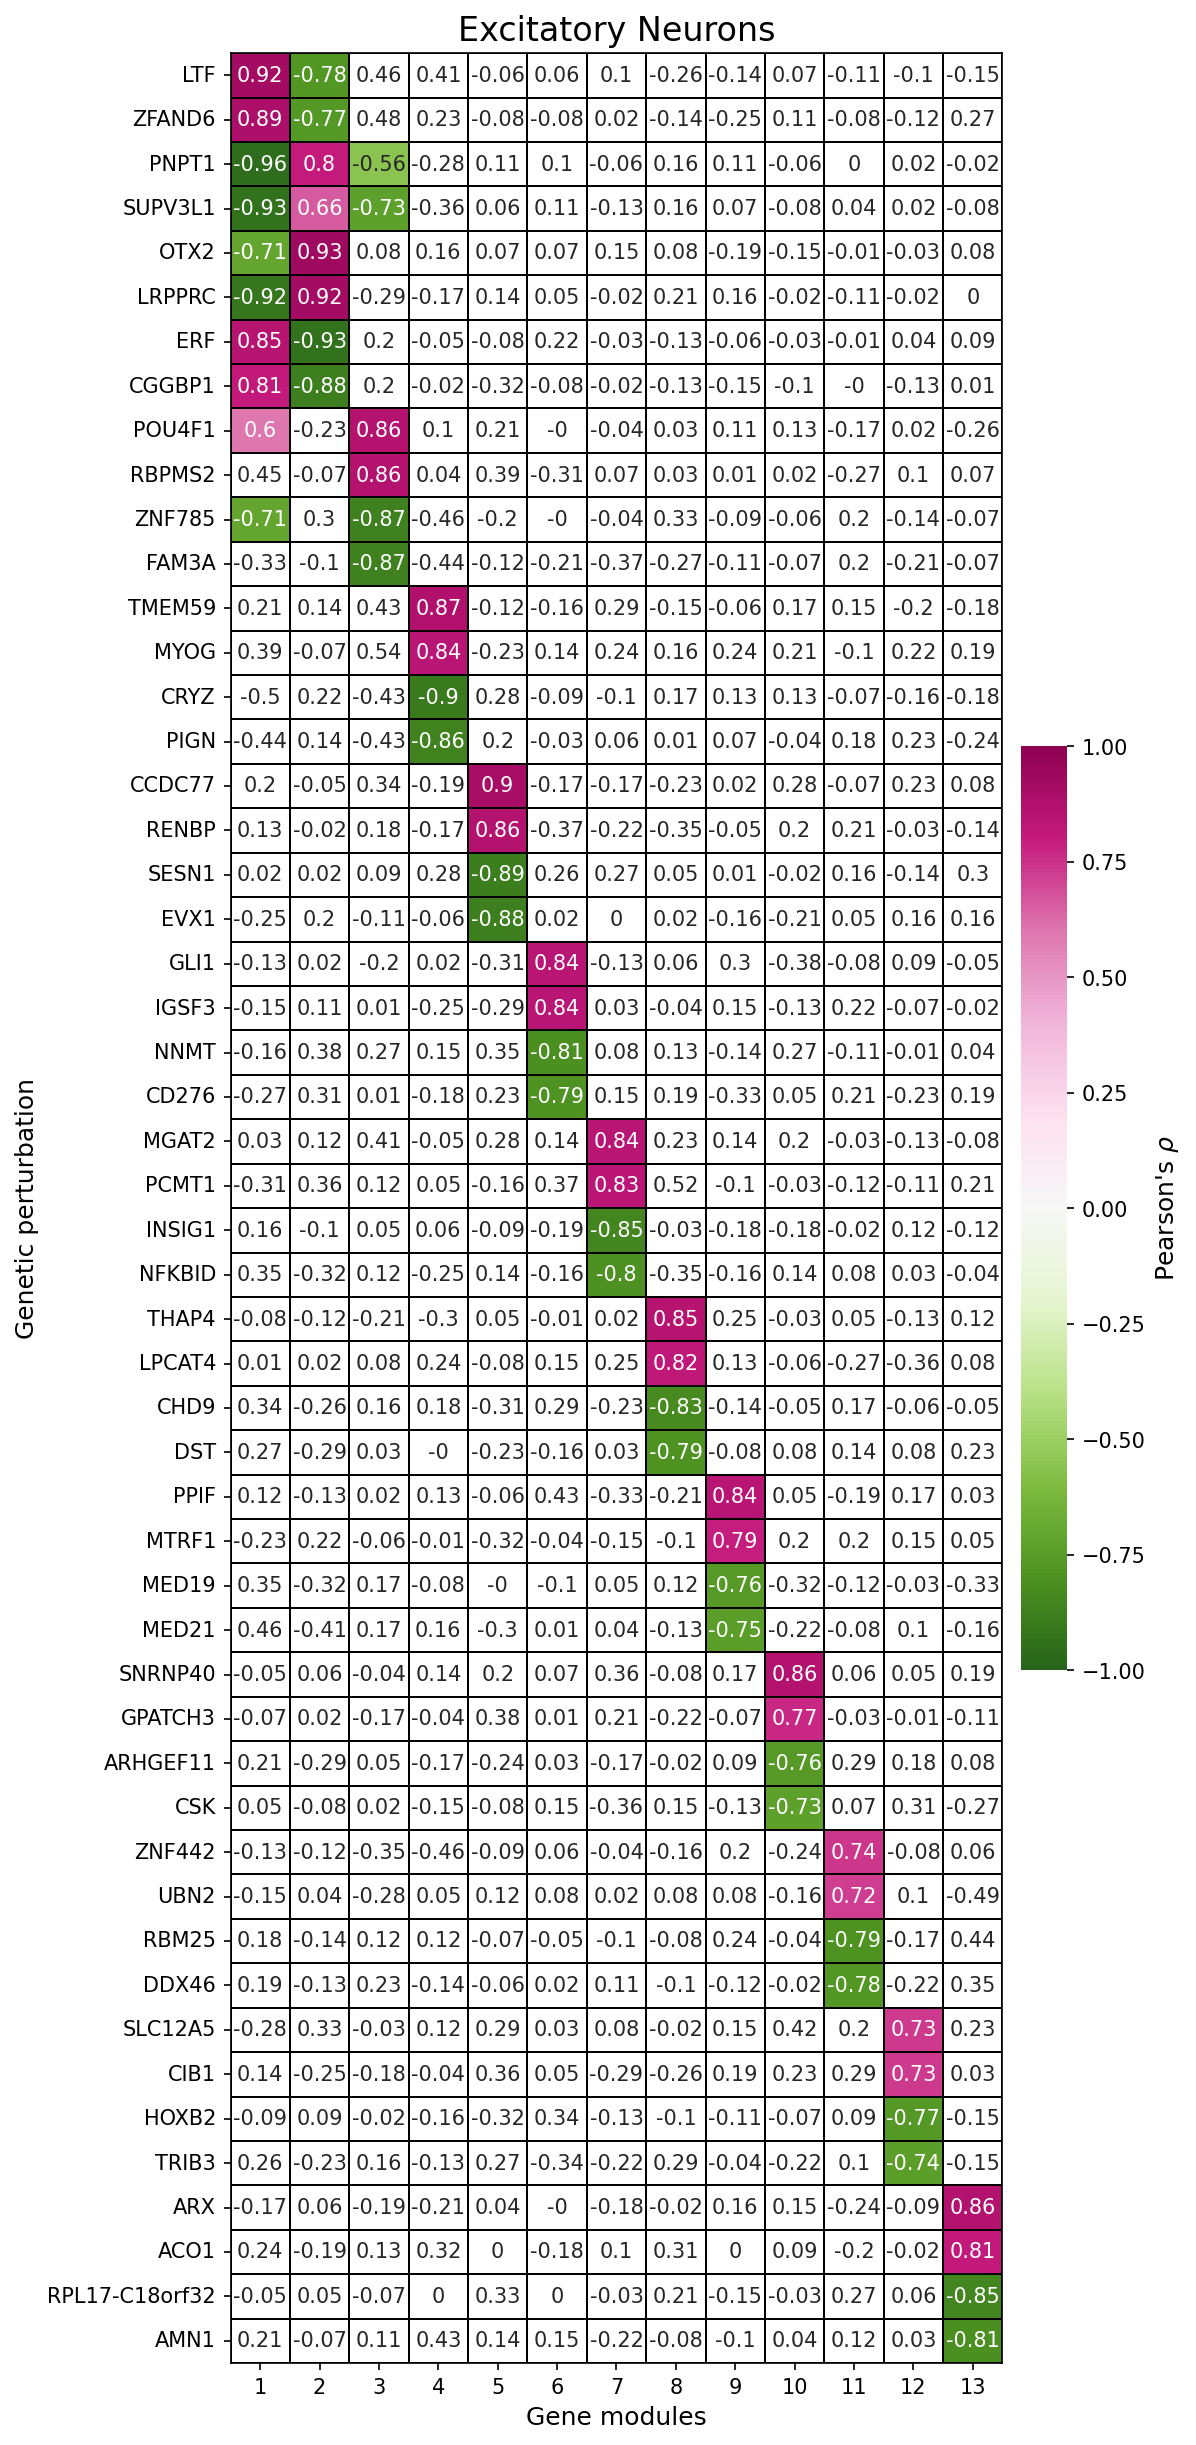

Inhibitory Neurons


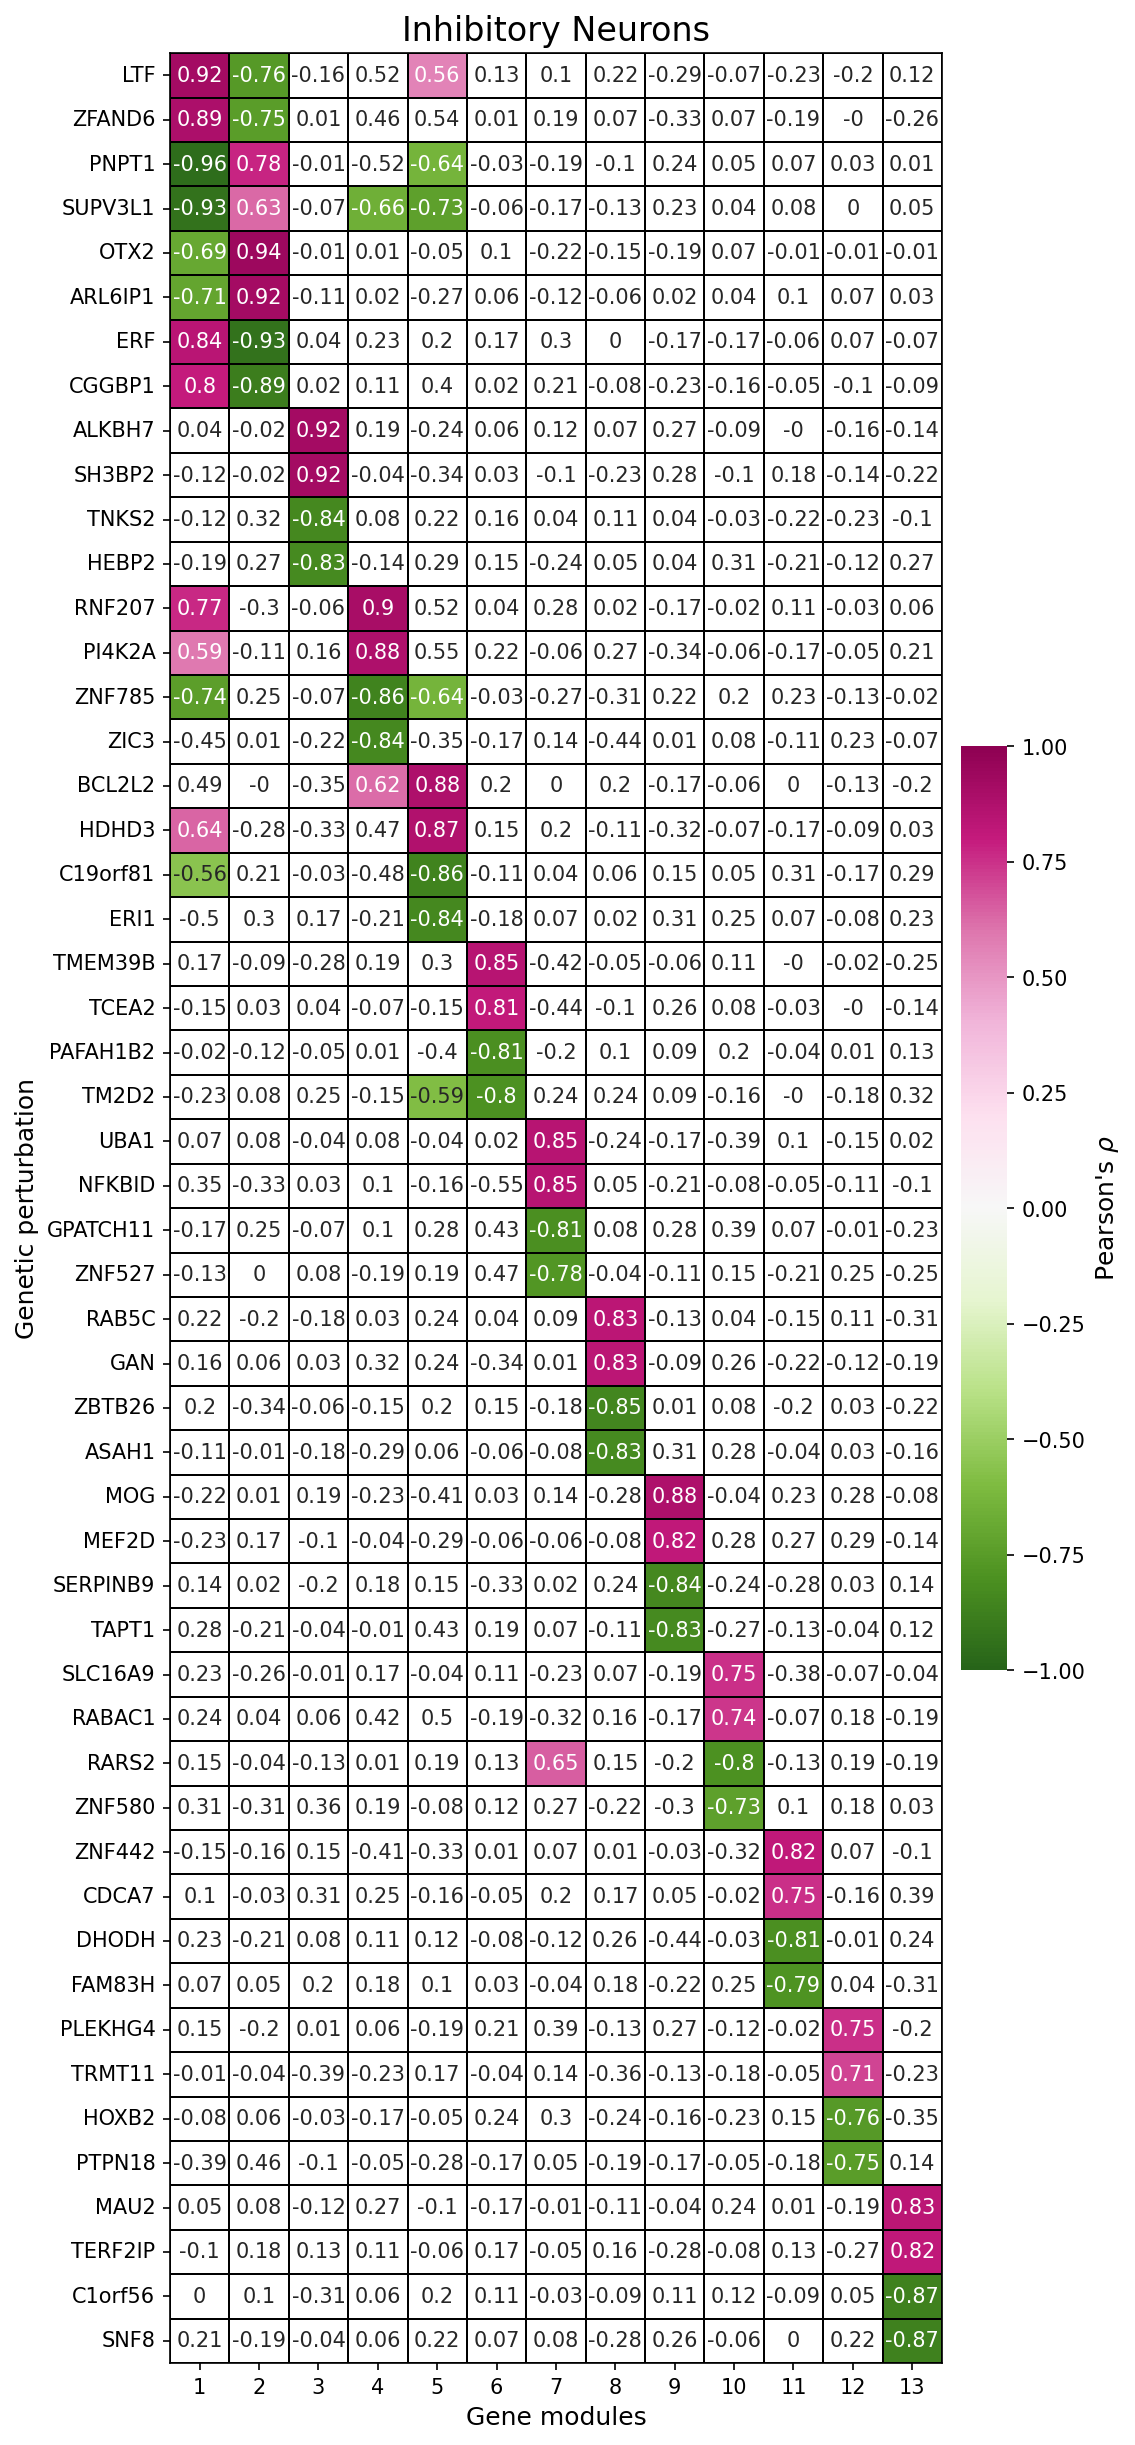

Oligodendrocytes


Astrocyte


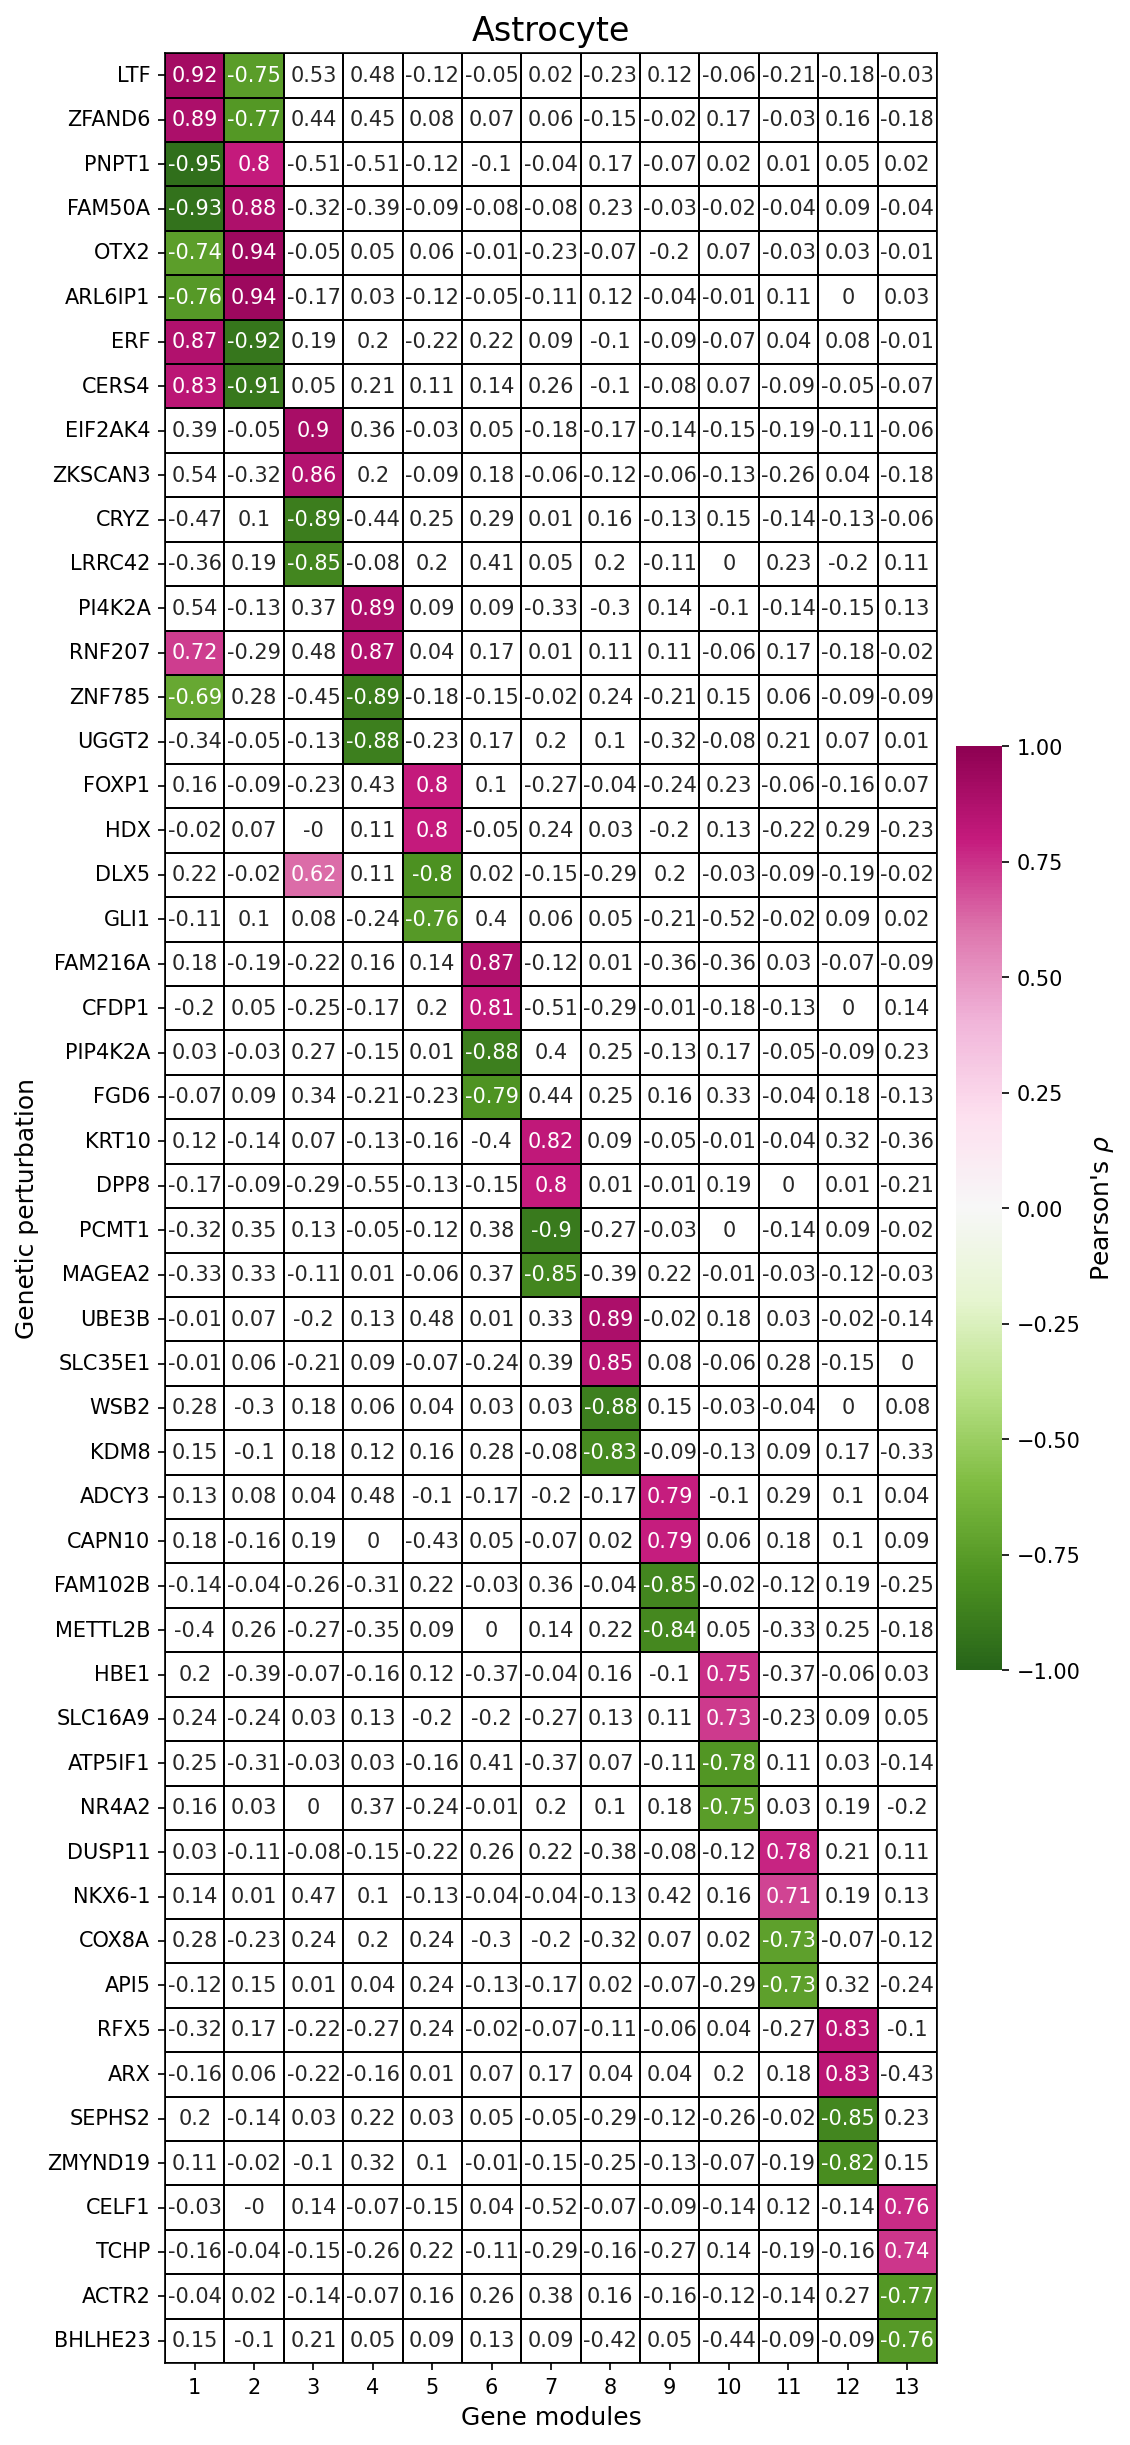

OPCs


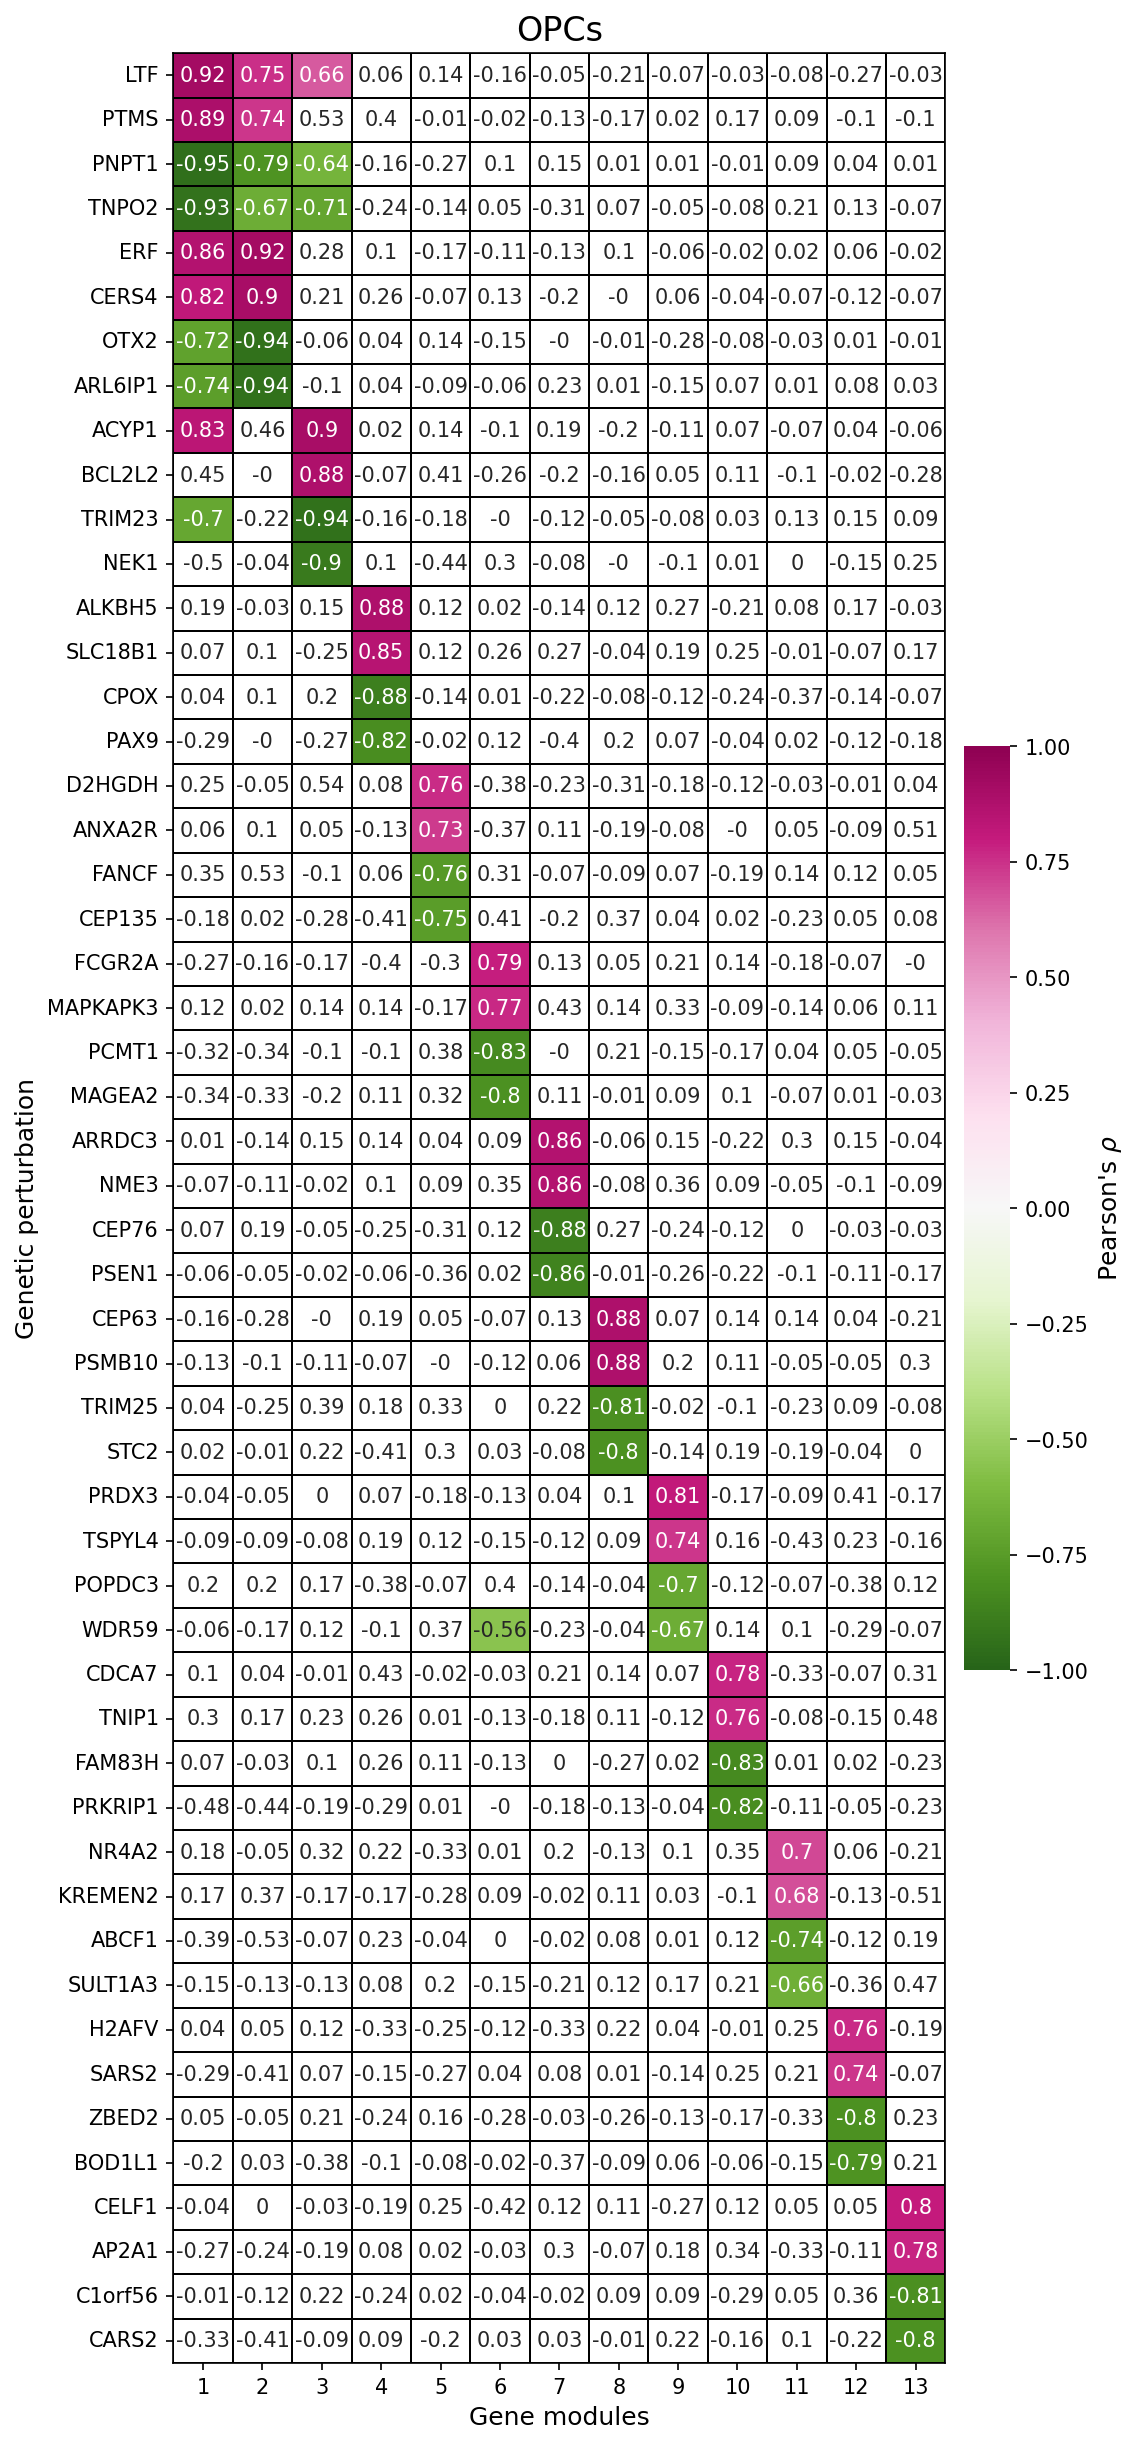

Microglia


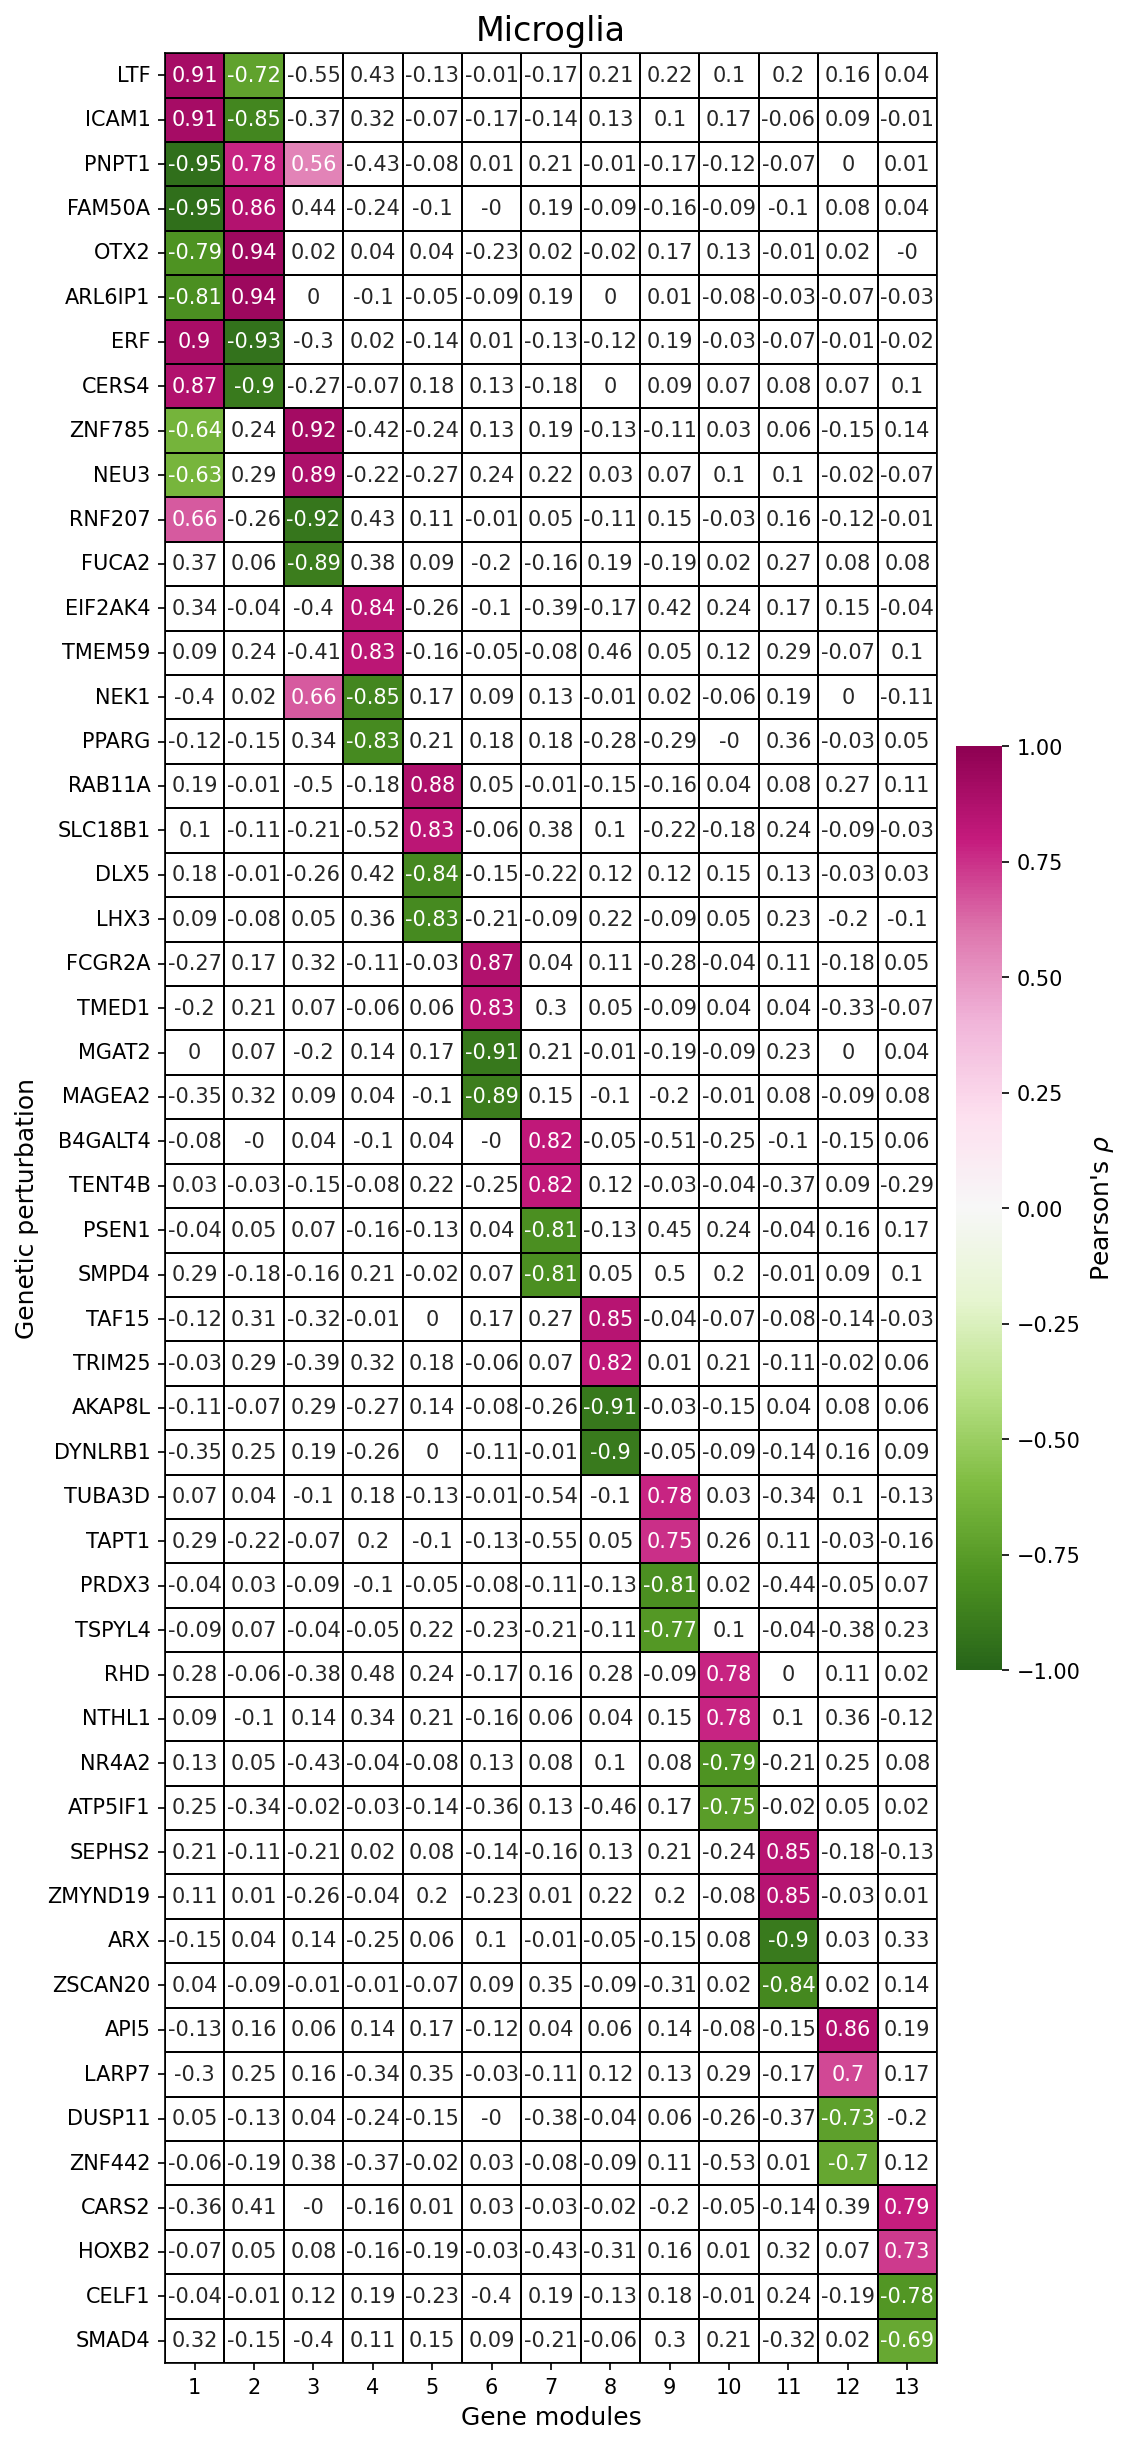

In [6]:
date = '08.13.25'
new_cols = ['comp_' + str(col) for col in range(1, 14)]
top_pert = dict()

pert_MT = pert_MT.loc[~pert_MT.index.str.contains("non-targeting")]

for cell_type in pls_cells[0:6]:
    print(cell_type)
    pls = joblib.load(f'{date}/MT_PLS/pls_{cell_type}.gz')
    genes = nuc_genes

    # loadings_df = pd.DataFrame(pls.x_loadings_,index=nuc_genes).loc[prot_genes]
    loadings_df = pd.DataFrame(pls.y_loadings_,index=MT_genes)
    
    corr_df = pd.DataFrame(np.corrcoef(loadings_df.T, pert_MT)[13:,0:13], columns= new_cols, index = pert_MT.index)

    N = 2  # number of top/bottom indices you want

    # --- Top N ---
    top_idx = np.argsort(-corr_df.values, axis=0)[:N, :]   # shape (N, n_cols)
    subset_top = pd.DataFrame(
        corr_df.index.to_numpy()[top_idx],  # ✅ convert to numpy first
        index=[f"top{i+1}" for i in range(N)],
        columns=corr_df.columns
    )

    # --- Bottom N ---
    bottom_idx = np.argsort(corr_df.values, axis=0)[:N, :]
    subset_bottom = pd.DataFrame(
        corr_df.index.to_numpy()[bottom_idx],  # ✅ convert to numpy first
        index=[f"bottom{i+1}" for i in range(N)],
        columns=corr_df.columns
    )

    subset_df = pd.concat([subset_top, subset_bottom])
    subset_df = subset_df.melt().set_index(['variable', 'value'])

    cleaned_id = []
    top_chem = []
    for comp, pert in subset_df.index:
        top_chem.append(pert)
        cleaned_id.append(pert.split('_')[1])

    # numpy implementation is much faster, but does not return p-values
    # corr_df = pd.DataFrame(np.corrcoef(loadings_df.T, pert_MT.loc[top_chem])[13:,0:13], columns= new_cols, index = cleaned_id)
    corr_instances = []
    pval_instances = []
    for col_name in top_chem:
        n_loadings=13
        corr_row = []
        pval_row = []
        for j in range(n_loadings):
            corr, pval = pearsonr(pert_MT.T[col_name], loadings_df.iloc[:, j])
            corr_row.append(corr)
            pval_row.append(pval)

        corr_df = pd.DataFrame([corr_row], columns=loadings_df.columns, index=[col_name])
        corr_instances.append(corr_df)

        pval_df = pd.DataFrame([pval_row], columns=loadings_df.columns, index=[col_name])
        pval_instances.append(pval_df)

    df = pd.concat(corr_instances)
    pval = pd.concat(pval_instances)

    plt.figure(dpi=150, figsize=(8,20))
    plt.title(cell_type, fontsize=16)
    fig1 = sns.heatmap(df.round(2).mask(pval>0.05), cmap= 'PiYG_r', vmax=1, vmin=-1, yticklabels= cleaned_id,
                xticklabels=range(1,14), annot=True, cbar_kws={"shrink": 0.4, "pad":0.02, "label":r"Pearson's $\rho$"})
   
    fig1.collections[0].colorbar.ax.yaxis.label.set_size(12) 
    
    fig2 = sns.heatmap(df.round(2).mask(pval<0.05), cmap= 'Greys', vmax=0, vmin=0, linecolor='black',
                yticklabels= cleaned_id, xticklabels=range(1,14), linewidths=0.2, annot=True, cbar=False)
    
    # Make all spines visible
    for spine in fig2.spines.values():
        spine.set_visible(True)
    
    plt.ylabel('Genetic perturbation', fontsize=12)
    plt.xlabel('Gene modules', fontsize=12)
    plt.savefig(f'material/CRISPR_perturbations/{cell_type}_pert_seq_top_2.png', bbox_inches='tight', dpi=200)
    plt.show()
    plt.close('all')

    top_pert[cell_type] = top_chem


In [7]:
# Identify loss-of-function perturbations
genes_to_look = set()
for top_cell in top_pert.values():
    for gene in top_cell:
        genes_to_look.add(gene)
        
# Clean perturbation name
cleaned_genes = []
for gene in list(genes_to_look):
    cleaned_genes.append(gene.split('_')[1])

In [8]:
cells_order = [
 'Excitatory Neurons',
 'Oligodendrocytes',
 'Inhibitory Neurons',
 'Astrocyte',
 'Microglia',
 'OPCs',
 'Endothelial',
 'Fibroblast',
 'Pericytes',
 'Macrophages',
 'SMC',
 'all_immune_cells',
 ]

In [9]:
# Reverse cell order
cells = cells_order[0:6].copy()
cells.reverse()

In [10]:
def heatmap(x, y, **kwargs):

    """
    Creates a scatter-based heatmap with optional color and size mapping, including legends.

    Parameters
    ----------
    x : list or array-like
        Categories or coordinates along the x-axis.
    y : list or array-like
        Categories or coordinates along the y-axis.
    **kwargs : dict
        Optional keyword arguments:
        - color : list or array-like
            Values mapped to colors of the points.
        - palette : list
            Color palette used for mapping values to colors.
        - color_range : tuple
            (center, min, max) range of values mapped to colors.
        - size : list or array-like
            Values mapped to sizes of the points.
        - size_range : tuple
            (min, max) range of values mapped to point sizes.
        - size_scale : float
            Scaling factor for point sizes.
        - x_order : list
            Custom order of x categories.
        - y_order : list
            Custom order of y categories.
        - xlabel, ylabel : str
            Axis labels.
        - x_tick_rotation, y_tick_rotation : int
            Rotation of tick labels.
        - fontsize : int
            Font size for tick labels.
        - num_size_label : int
            Number of labels shown on the size legend.
        - size_labels : list
            Custom size labels for the size legend.
        - facecolor : str
            Background color of the heatmap.
        - marker : str
            Marker style for points.
        - m_color : str
            Color of points in the size legend.
        - Additional plotting arguments are passed to matplotlib.scatter.

    Returns
    -------
    ax : matplotlib.axes.Axes
        Axes of the main heatmap plot.
    ax1 : matplotlib.axes.Axes
        Axes of the color legend.
    ax2 : matplotlib.axes.Axes
        Axes of the size legend.
    size_labels : list
        Numeric labels used for the size legend.

    Notes
    -----
    - Both color and size can be used to encode values in the heatmap.
    - Includes automatic legends for color and size.
    - Handles categorical or numeric axes and allows custom ordering.
    """

    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_center, color_min, color_max = kwargs['color_range']
    else:
        color_center, color_min, color_max = np.mean(color), min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    x_rot = kwargs.get('x_tick_rotation', 45)
    y_rot = kwargs.get('y_tick_rotation', 0)
    fontsize = kwargs.get('fontsize', 14)
    num_size_label = kwargs.get('num_size_label', 4)
    size_labels = kwargs.get('size_labels', [])
    facecolor = kwargs.get('facecolor', '#FFFFFF')

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val, size_scale = size_scale):
        if val==-1:
            return 0
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
        
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in set([v for v in x])]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in set([v for v in y])]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 21, hspace=1, wspace=0) # Setup a 1x10 grid

    ax = plt.subplot(plot_grid[:,:16]) # Use the left 14/16ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', \
         'marker', 'x_order', 'y_order', 'xlabel', 'ylabel', 'x_tick_rotation', \
         'y_tick_rotation','fontsize', 'num_size_label','m_color', 'size_labels', 'facecolor'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k+1 for k in x_to_num], rotation=x_rot, horizontalalignment='right', fontsize=fontsize)
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num], rotation=y_rot, fontsize = 14)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor(facecolor) #palette[len(palette)//2]) #'#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''), fontsize=14)
    ax.set_ylabel(kwargs.get('ylabel', ''), fontsize=fontsize)

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax1 = plt.subplot(plot_grid[:,-3]) # Use the rightmost-1 column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax1.barh(
            y=bar_y,
            width=[1.33]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0,
        )
        ax1.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax1.grid(False) # Hide grid
        ax1.set_xticks([]) # Remove horizontal ticks
        ax1.set_yticks(np.linspace(min(bar_y), max(bar_y), num_size_label), labels=np.linspace(min(bar_y), max(bar_y), num_size_label).round(0), fontsize=14) # Show vertical ticks for min, middle and max
        ax1.yaxis.tick_left() # Show vertical ticks on the right
        # ax1.bar_label('NES')
        #ax1.set_axis_off()
        
    for spine in ax1.spines.values():
        spine.set_visible(False)

    # Plot the size reference
    ax2 = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot 
    # print(y_len)
    print(y_to_num)
    size_labels = np.linspace(kwargs['size_range'][0], kwargs['size_range'][1], num_size_label).tolist()
    y_len = len(size_labels)
    ss = size_labels + [-1]*(y_len-len(size_labels))
    print(ss)
    print([value_to_size(v, size_scale=size_scale) for v in ss])
    ax2.scatter(
        x=[2]*y_len,
        y=np.arange(0,y_len),
        marker=marker,
        s=[value_to_size(v, size_scale=size_scale) for v in ss],
        c=kwargs.get('m_color','black'),
        **kwargs_pass_on
    )
    ax2.grid(False) # Hide grid
    ax2.set_facecolor('white')
    ax2.set_xticks([])
    ax2.set_yticks(np.arange(0,y_len), labels = ss, fontsize=14)

    ax2.yaxis.tick_right()

    ax2.patch.set_visible(False) 
    for spine in ax2.spines.values():
        spine.set_visible(False)

    return ax, ax1, ax2, size_labels

In [11]:
def costum_heatmap(df, pval, pert):

    """
    Creates a custom heatmap for visualizing gene module associations with significance.

    Each cell in the heatmap represents a gene module (x-axis) and a cell type (y-axis),
    with color indicating effect size (e.g., NES) and size indicating statistical significance.

    Parameters
    ----------
    df : pandas.DataFrame
        Matrix of effect sizes (e.g., NES values) with rows as cell types and columns as gene modules.
    pval : pandas.DataFrame
        Matrix of p-values corresponding to `df`, same shape as `df`.
    pert : str
        Title for the heatmap (e.g., the name of the perturbation or condition).

    Returns
    -------
    ax : matplotlib.axes.Axes
        Axes of the main heatmap plot.
    ax1 : matplotlib.axes.Axes
        Axes of the color legend (effect sizes).
    ax2 : matplotlib.axes.Axes
        Axes of the size legend (significance, -log10(p-values)).

    Notes
    -----
    - Uses the `heatmap` function internally.
    - Color is mapped to effect sizes (`df.values`) with a diverging palette centered at 0.
    - Size is mapped to `-log10(pval)` to highlight statistical significance.
    - Includes legends for both color and size.
    - Axes labels and title are automatically set for readability.
    """

    x = np.tile(df.columns, len(df.index))
    y = np.repeat(df.index, len(df.columns))

    size = -np.log10(pval.values.flatten())

    color = df.values.flatten()
    palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]

    f = plt.figure(figsize=(10, 3.5), dpi=200)

    ax, ax1, ax2, ss = heatmap(
        x=x,
        y=y,
        y_order = cells,
        size=size,             # inverse p-values
        size_scale=700,
        size_range = (0,5),
        color=color,           # NES values
        color_range=(0, -1, 1),  # ✅ center=0, min=-2, max=2
        palette=palette,
        marker='s',
        fontsize=14,
        x_tick_rotation=90,
        num_size_label=3,
        m_color='black',
        # size_labels=[5,50,500]
    )

    cmap = plt.get_cmap("PiYG_r")
    norm = mcolors.Normalize(vmin=-1, vmax=1)  # <-- use your actual NES range

    # Get RGBA color for NES = 0
    color_at_zero = cmap(norm(0))
    ax.set_facecolor(color_at_zero) # Make background white

    ax1.set_ylabel(r"Pearson's $\rho$", fontsize=16, rotation=-90, labelpad=4)
    ax1.yaxis.set_label_position("right")

    ax2.set_ylabel('-log10(p)', rotation=270, fontsize=16, labelpad=20)
    ax2.yaxis.set_label_position("right")

    ax.set_title(pert, fontsize=18)
    ax.set_xlabel('Gene modules')

    return ax, ax1, ax2

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


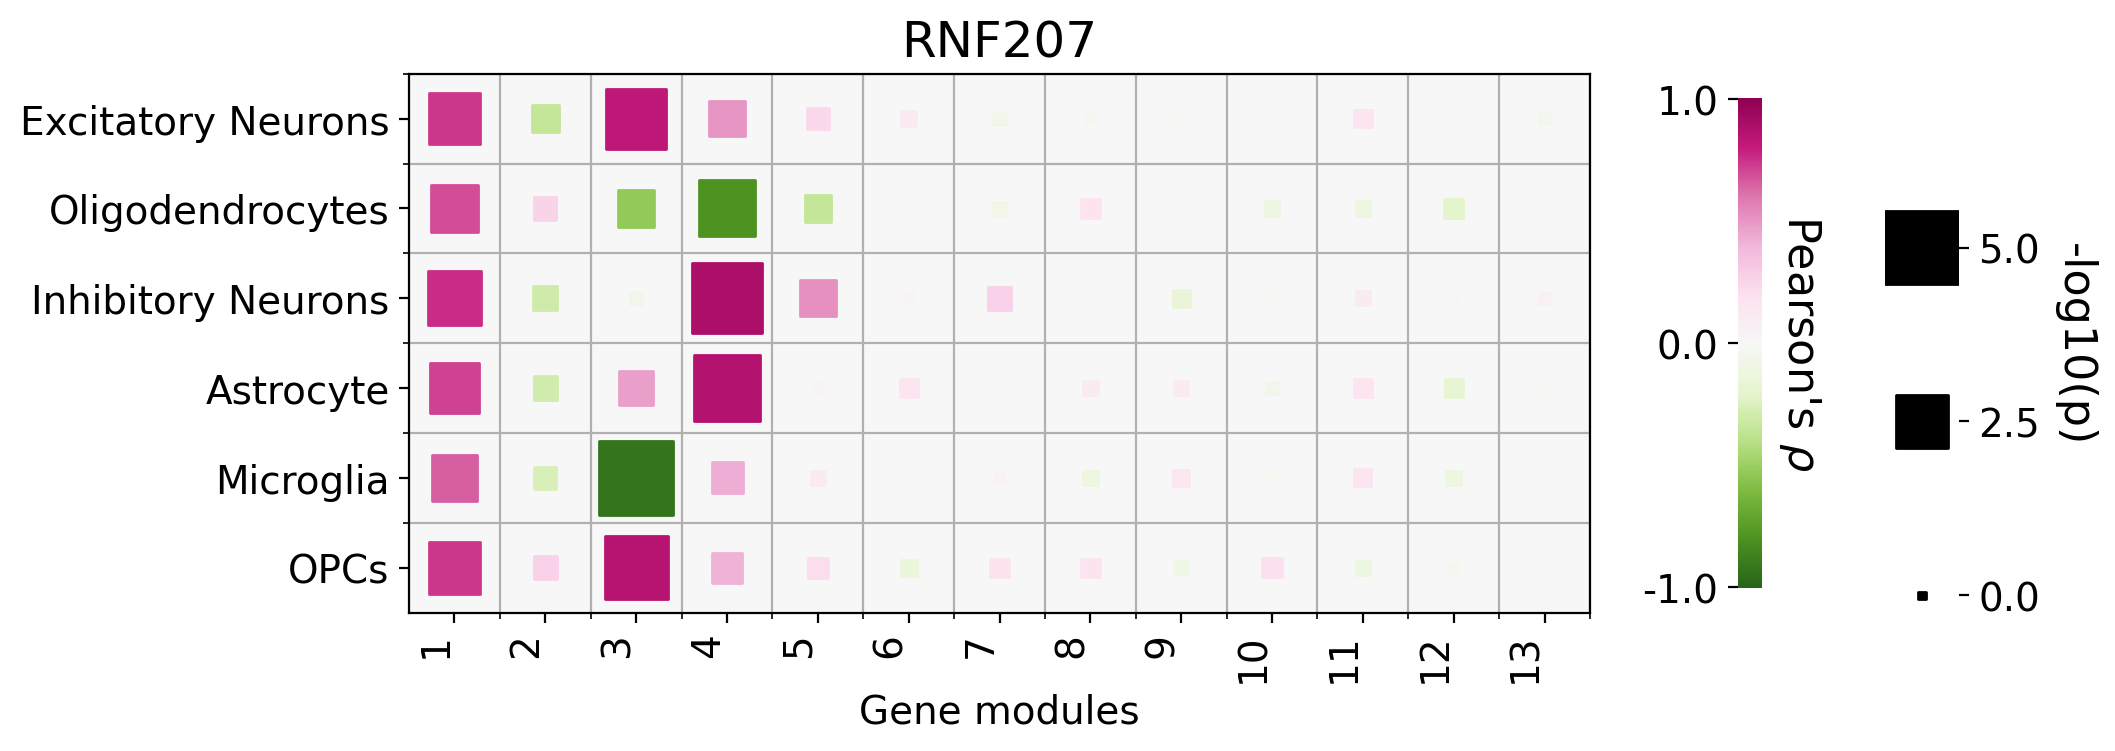

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


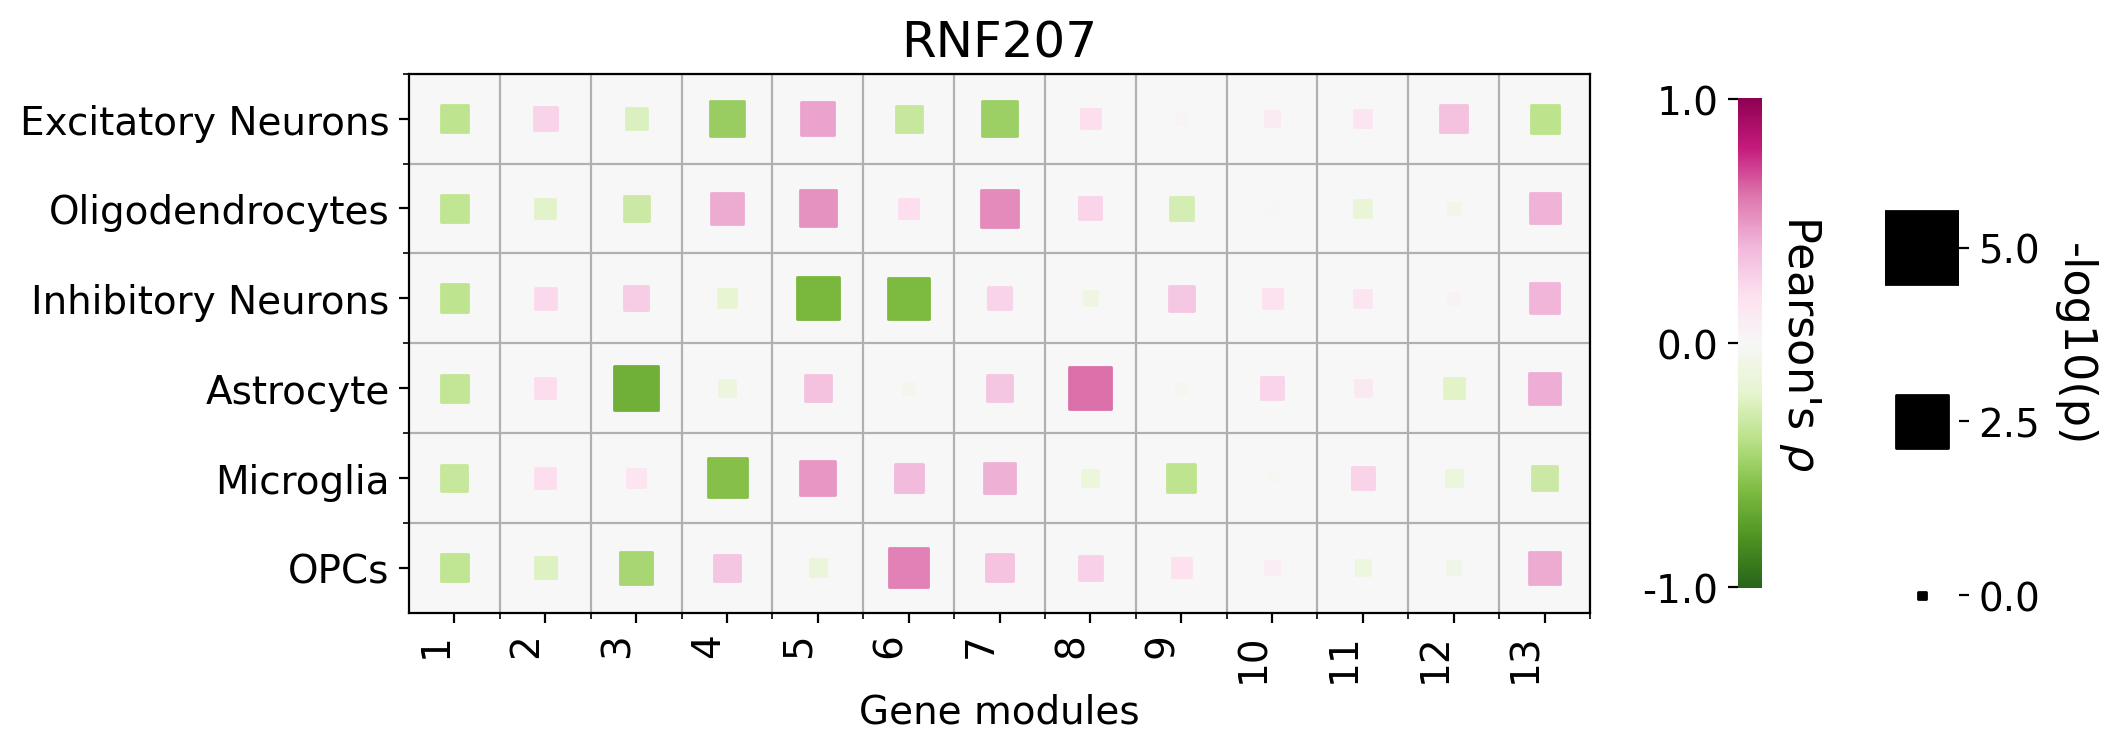

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


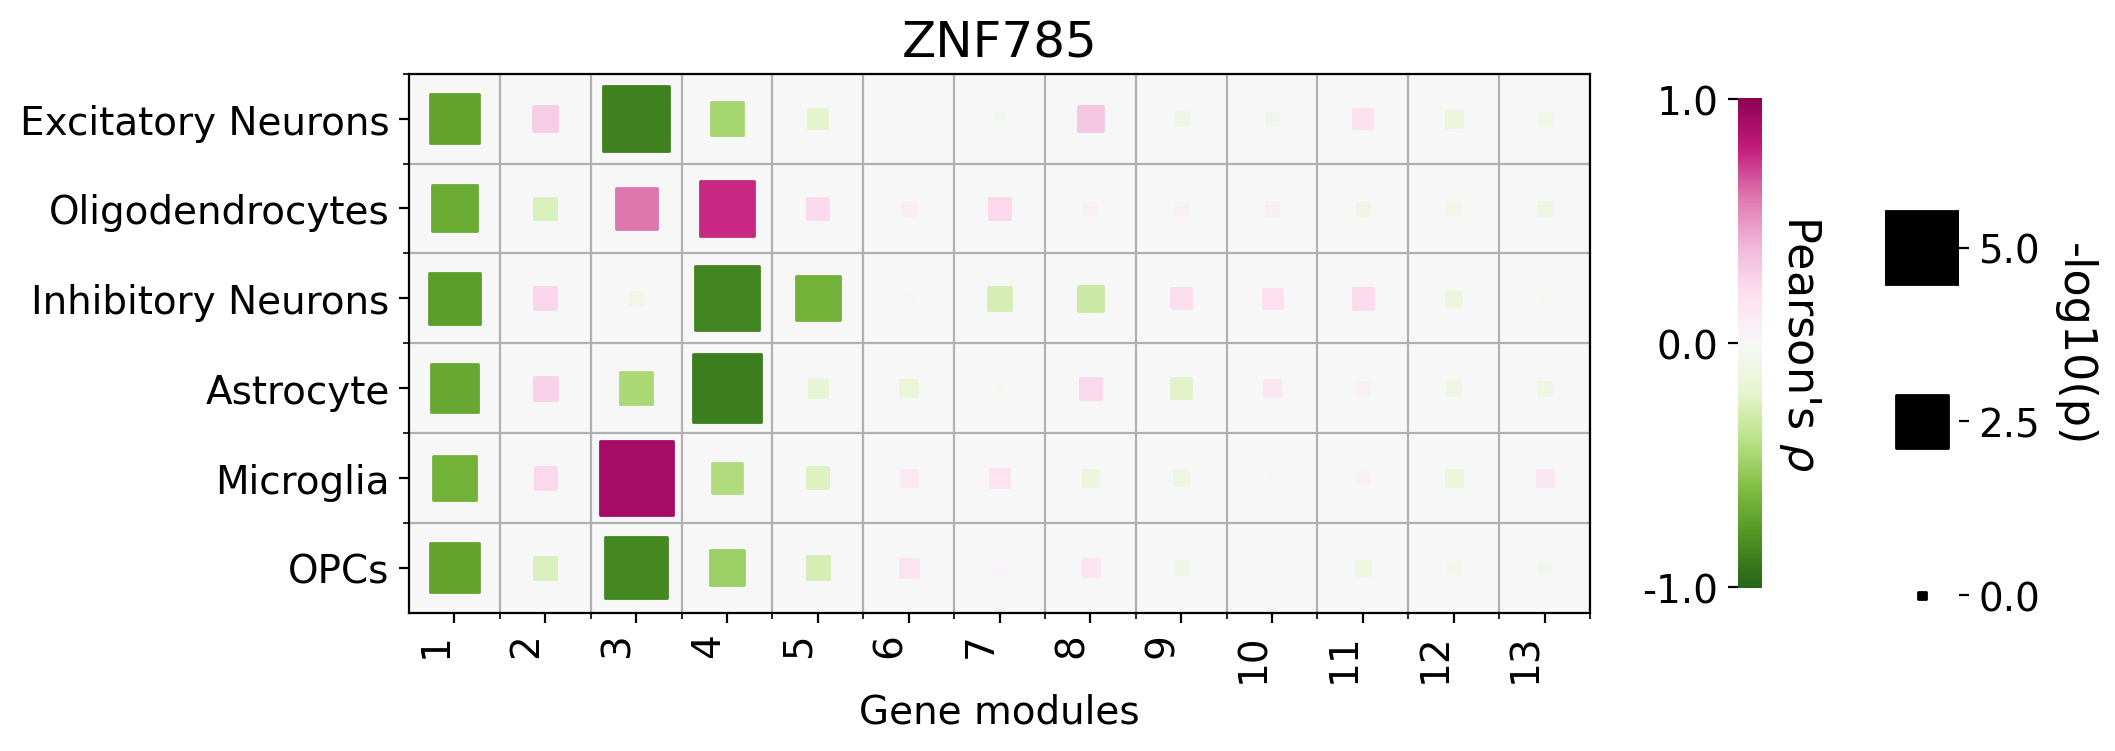

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


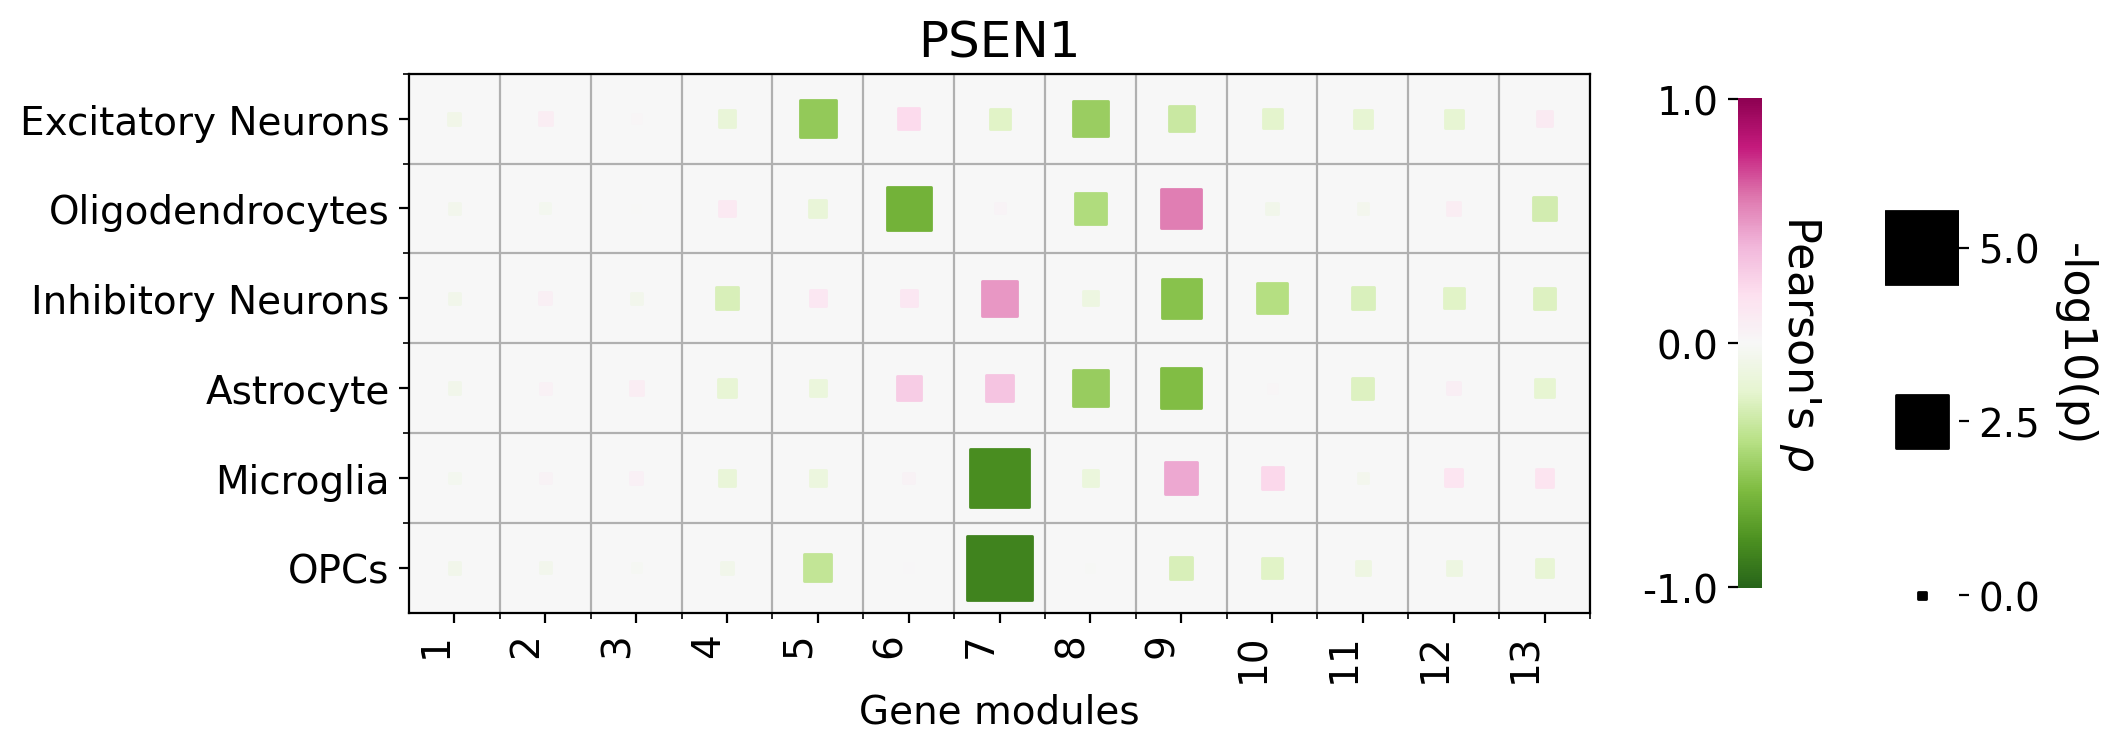

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


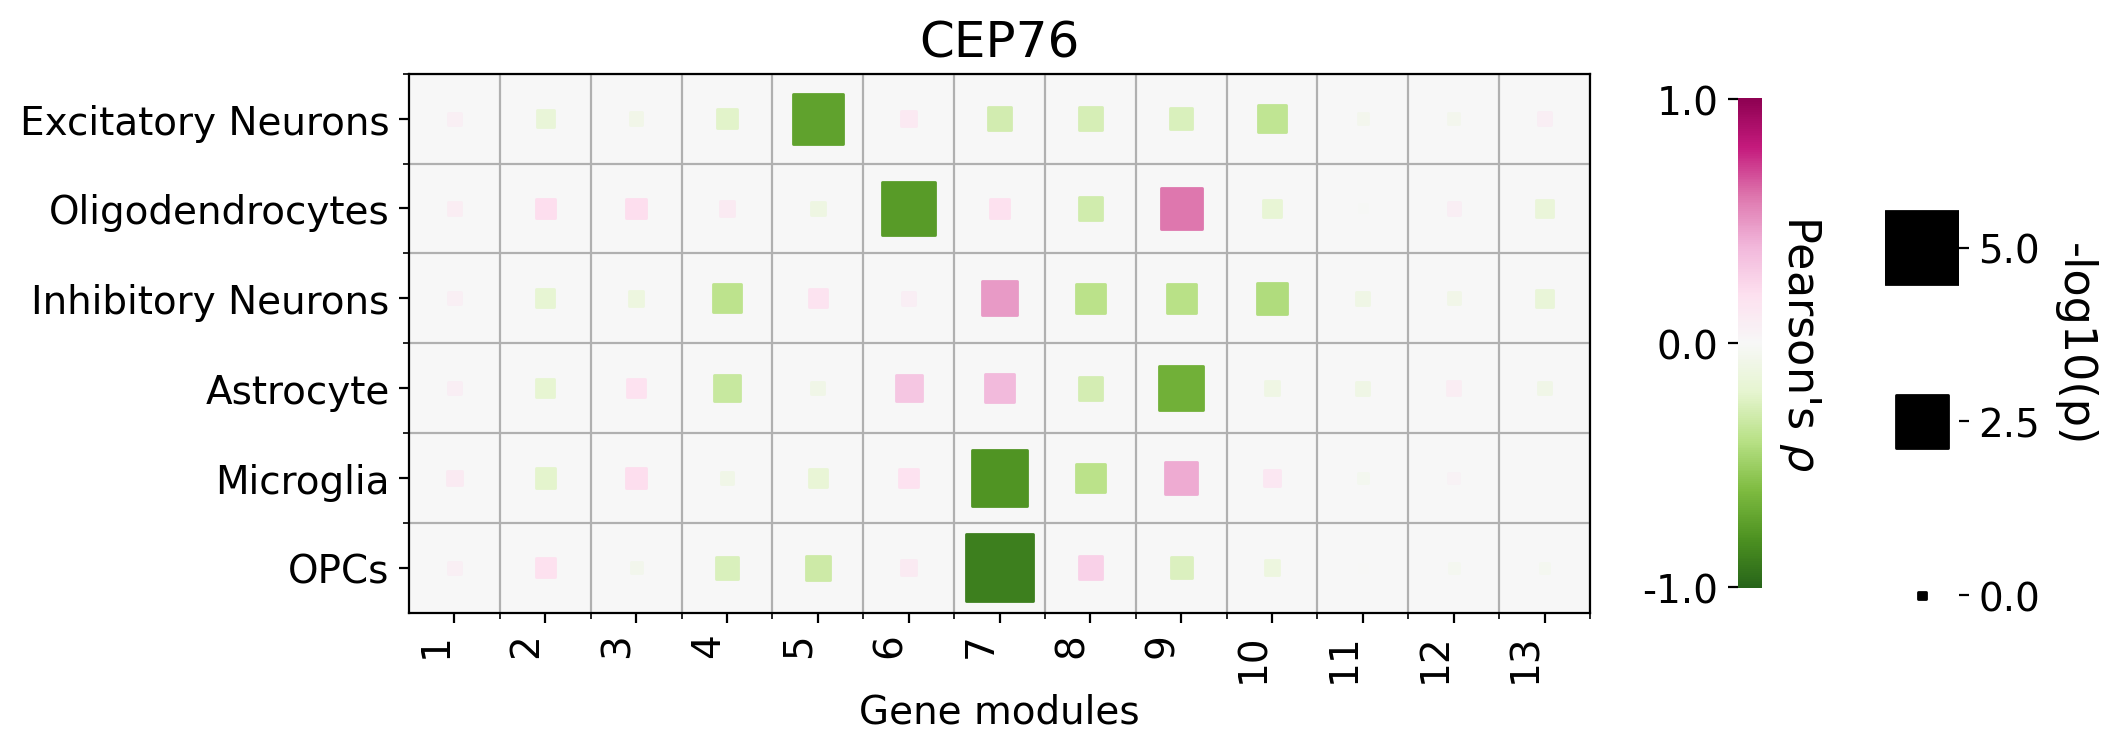

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


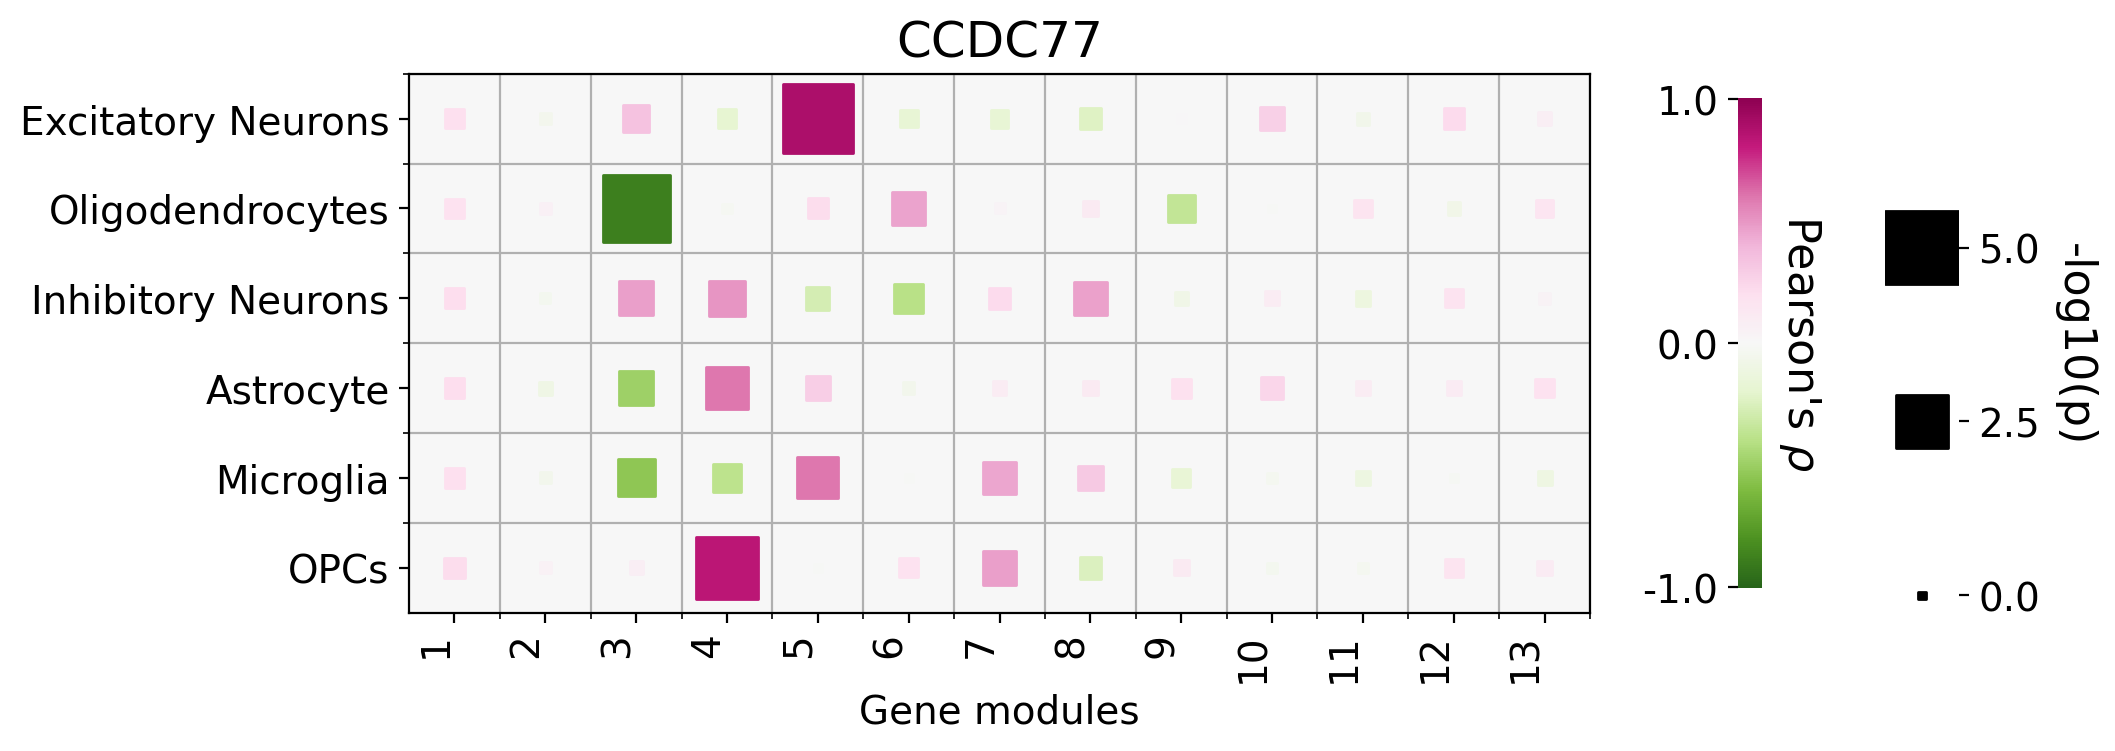

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


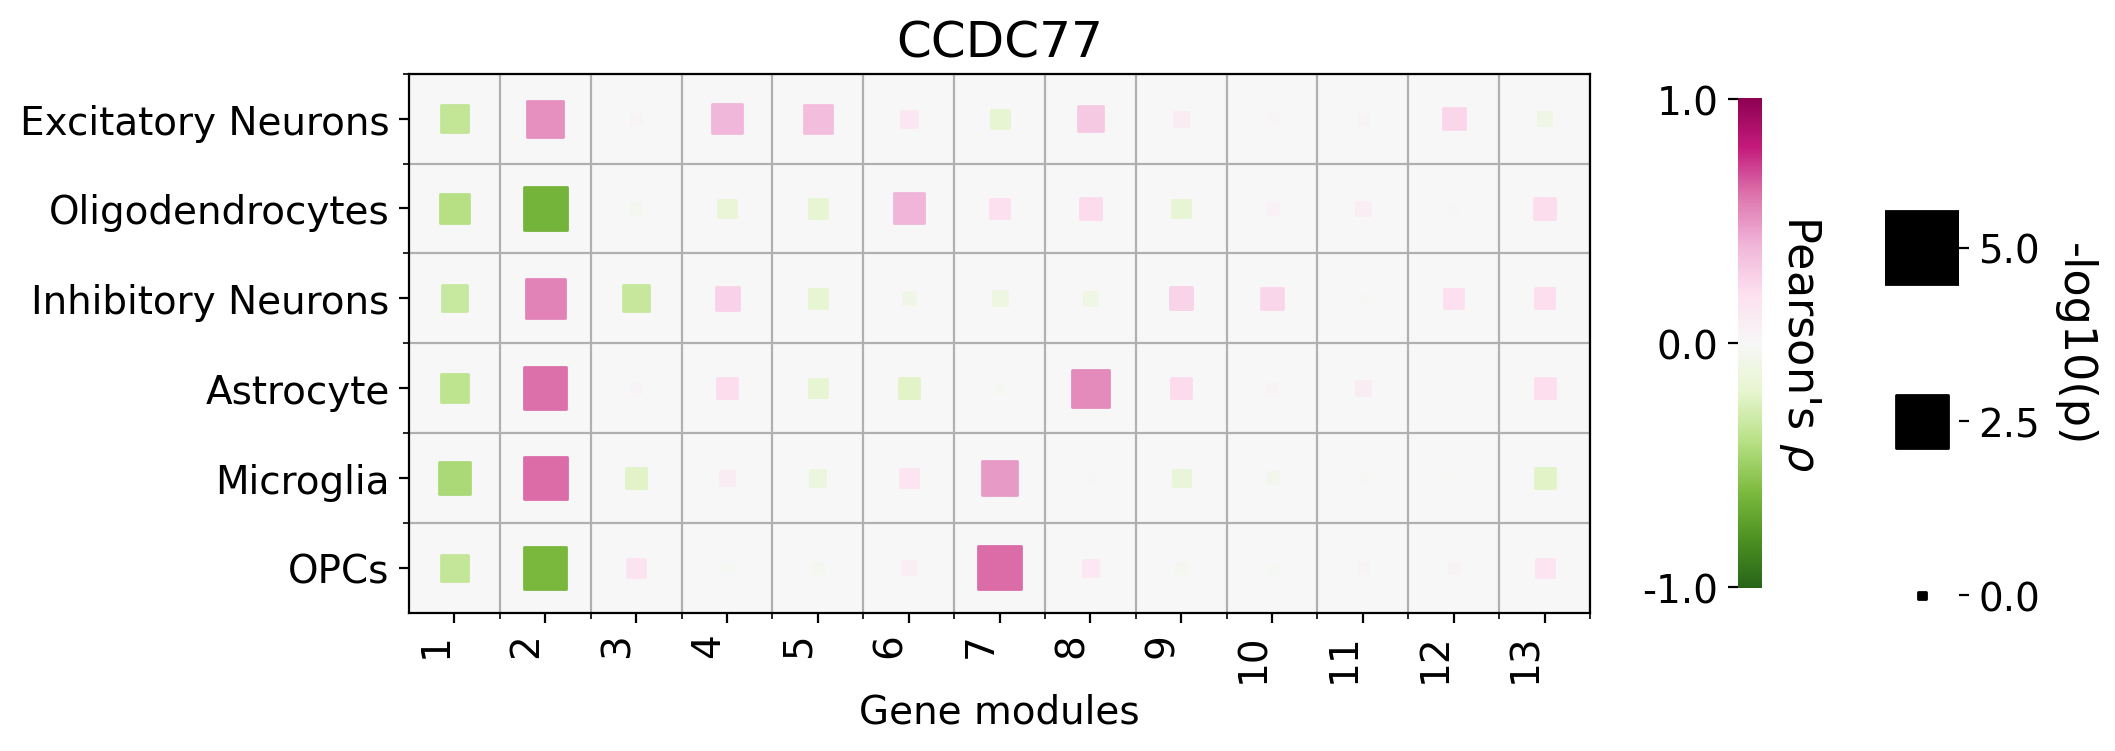

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


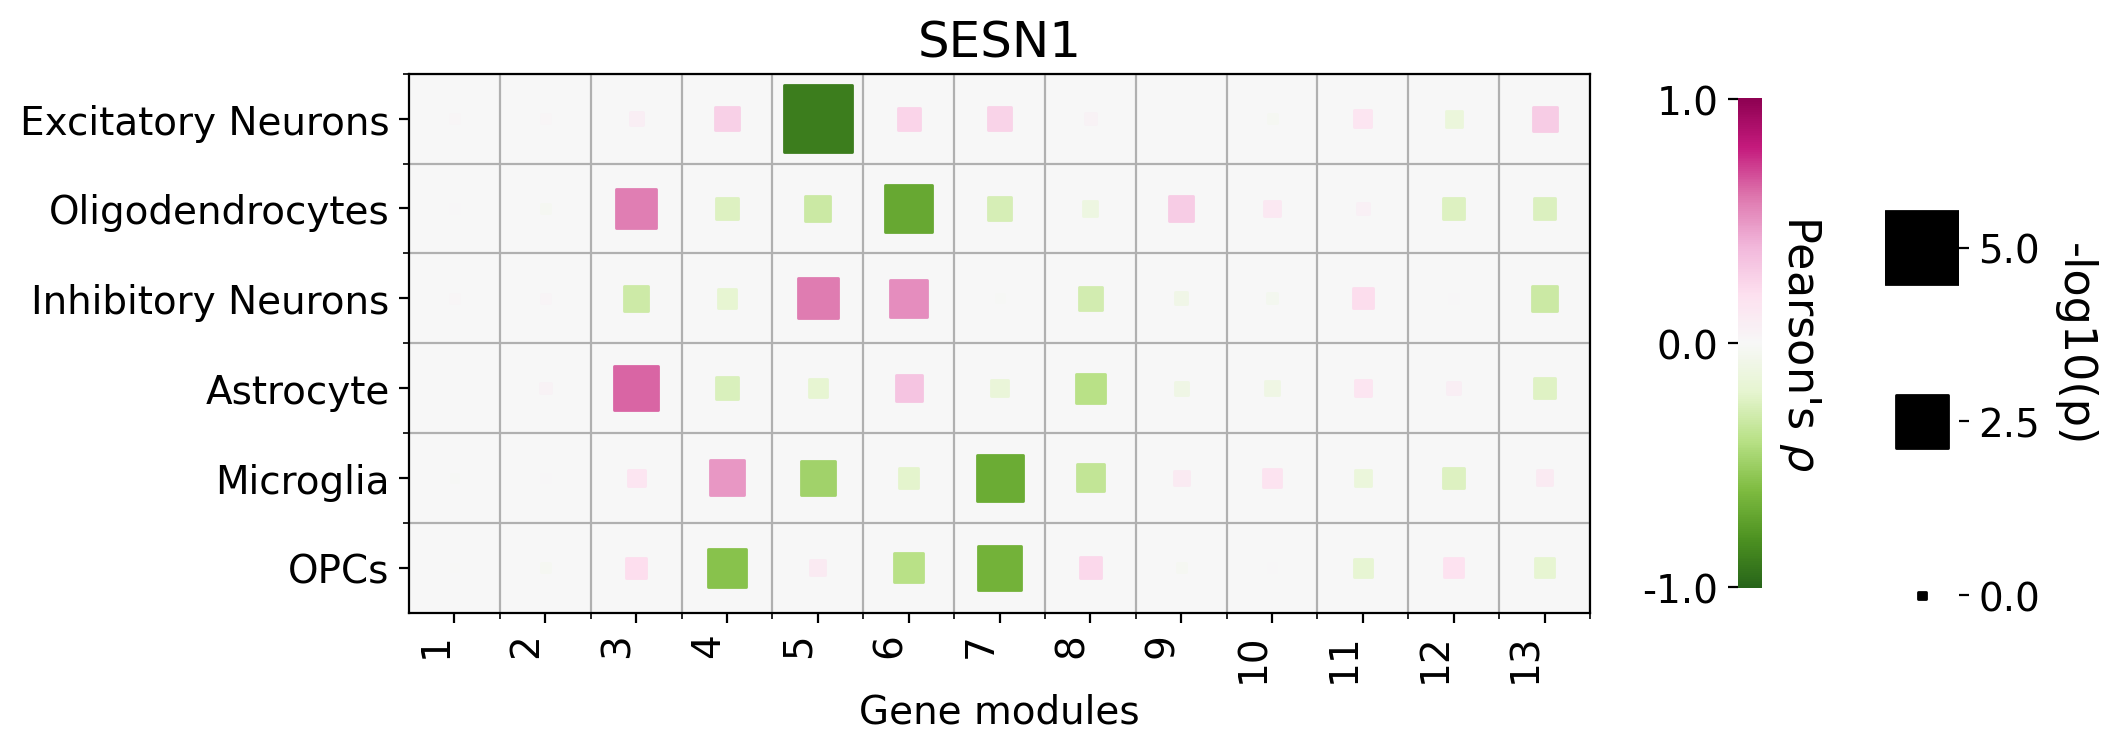

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


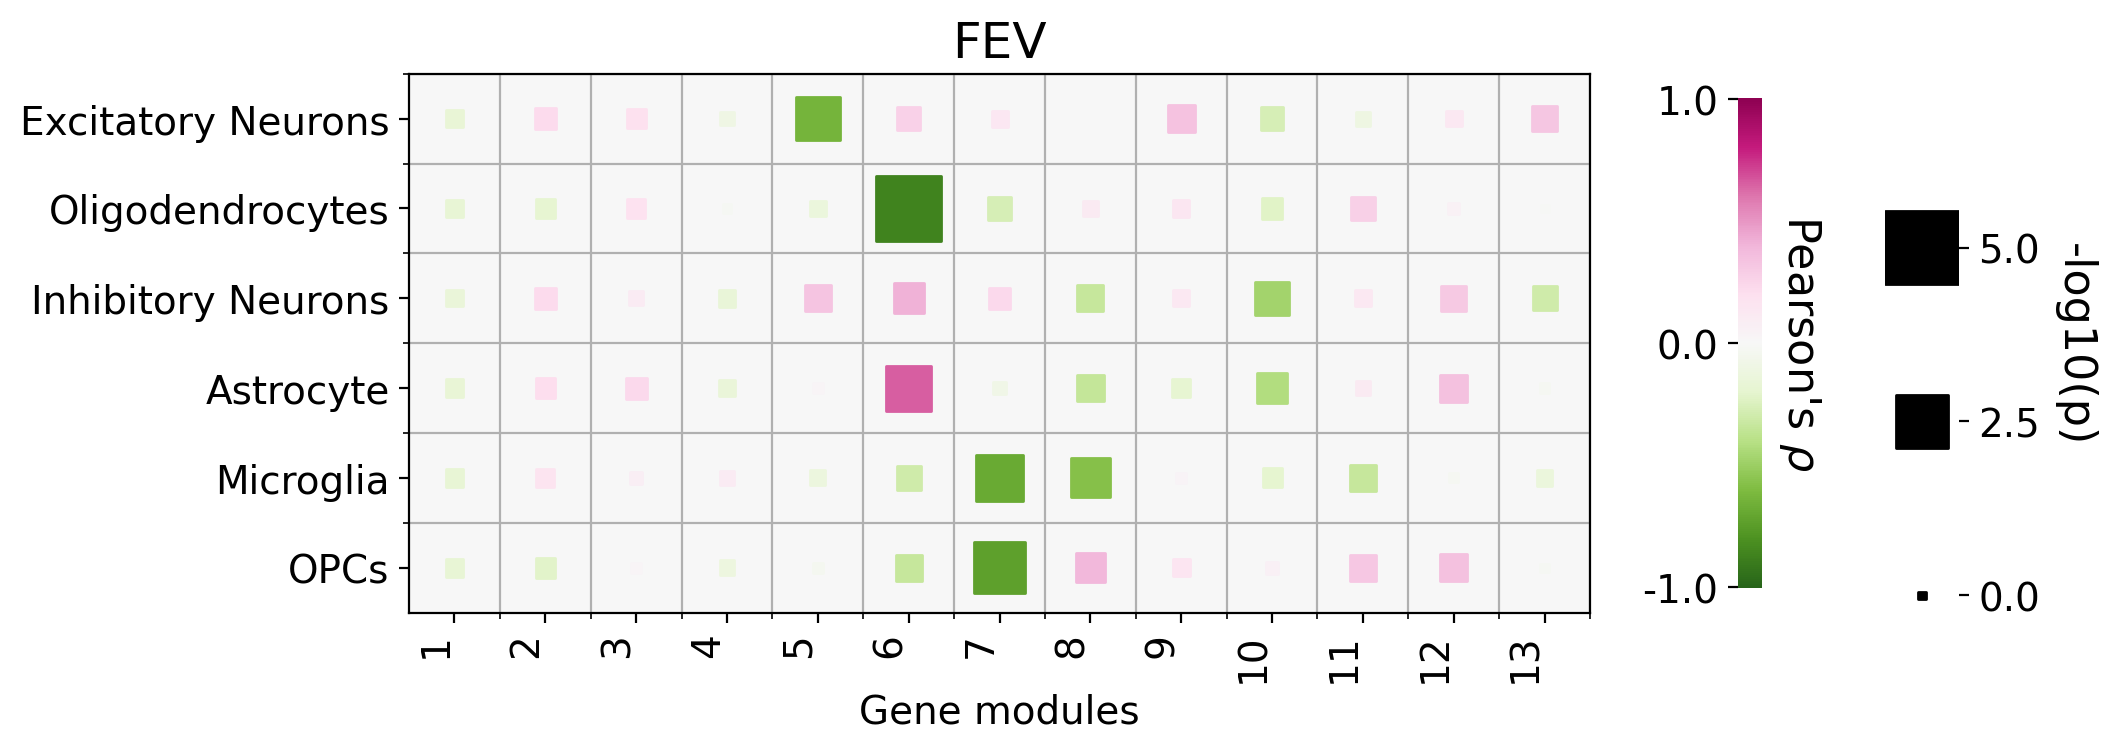

/tmp/ipykernel_1018591/2068415611.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = [plt.cm.get_cmap("PiYG_r")(i) for i in np.linspace(0, 1, 256)]
/tmp/ipykernel_1018591/2860087158.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'OPCs': 0, 'Microglia': 1, 'Astrocyte': 2, 'Inhibitory Neurons': 3, 'Oligodendrocytes': 4, 'Excitatory Neurons': 5}
[0.0, 2.5, 5.0]
[7.0, 353.5, 700.0]


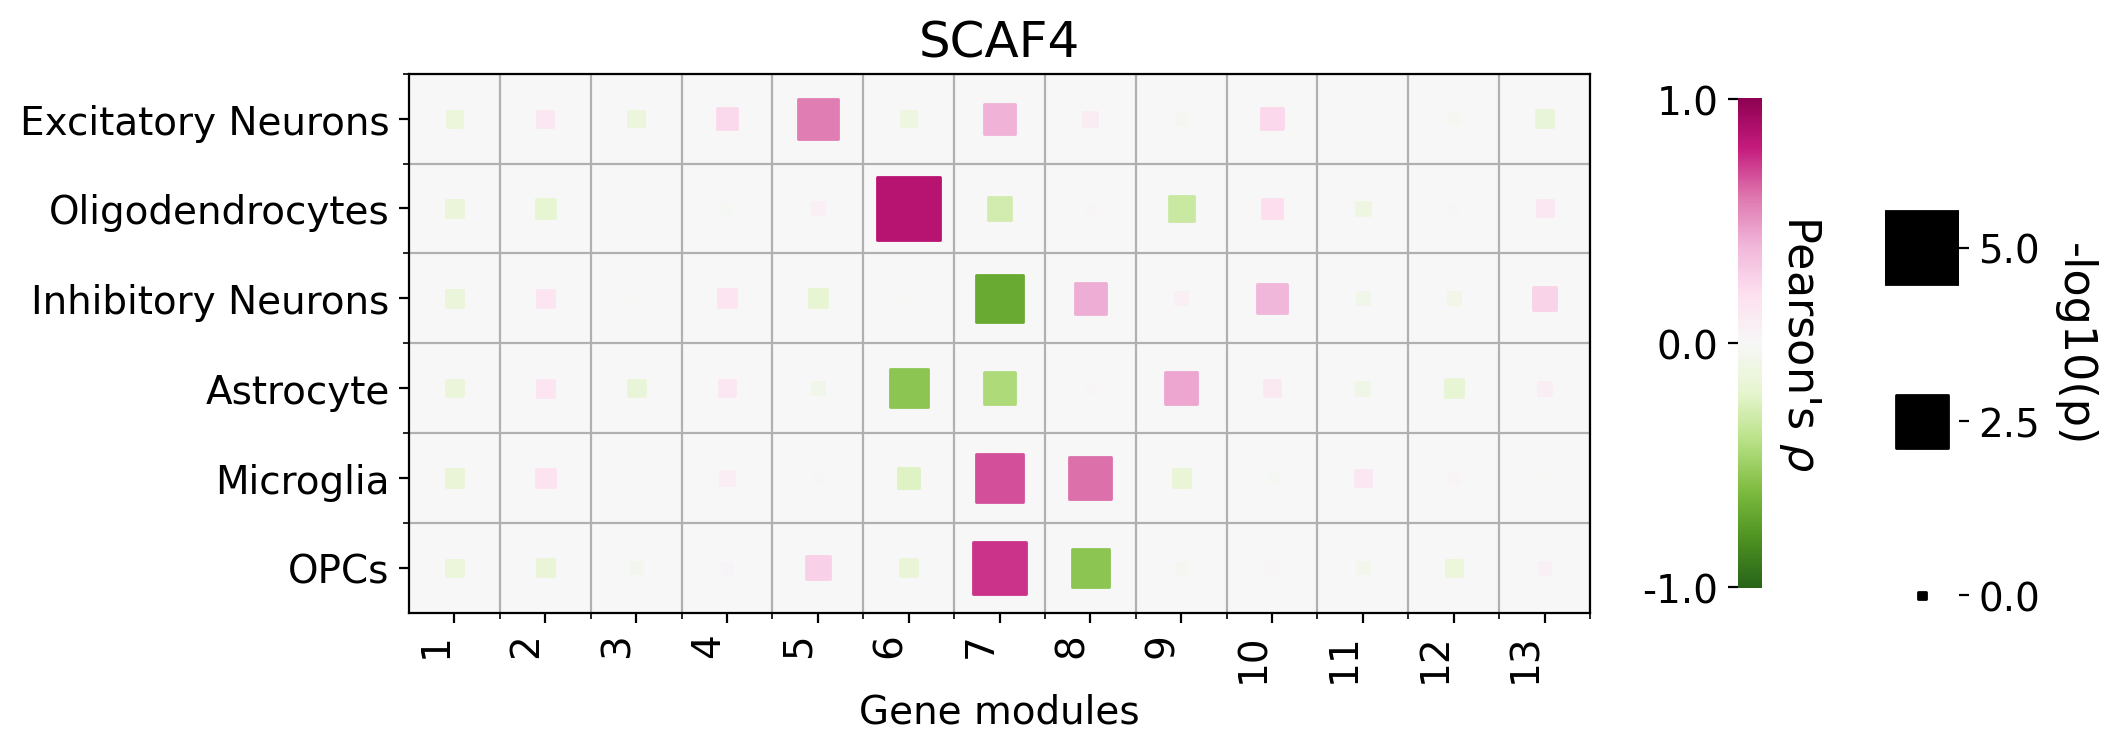

In [12]:
new_cols = ['comp_' + str(col) for col in range(1, 14)]
pert_list_to_plot = ['RNF207', 'ZNF785', 'PSEN1', 'CEP76', 'CCDC77', 'SESN1', 'FEV', 'SCAF4']

# clean column names
pert_MT_T = pert_MT.T.copy()

for pert in pert_list_to_plot:
    pert_cols = pert_MT_T.columns[pert_MT_T.columns.str.contains(pert)]

    for col_name in pert_cols:
        corr_instances = []
        pval_instances = []
        pert_cells_list = []

        for cell_type in cells_order[0:6]:
            pls = joblib.load(f'{date}/MT_PLS/pls_{cell_type}.gz')
            loadings_df = pd.DataFrame(pls.y_loadings_, index=MT_genes)
            n_loadings = loadings_df.shape[1]
            
            corr_row = []
            pval_row = []
            for j in range(n_loadings):
                corr, pval = pearsonr(pert_MT_T[col_name], loadings_df.iloc[:, j])
                corr_row.append(corr)
                pval_row.append(pval)
            
            cell_df = pd.DataFrame([corr_row], columns=loadings_df.columns, index=[cell_type])
            corr_instances.append(cell_df)

            cell_df = pd.DataFrame([pval_row], columns=loadings_df.columns, index=[cell_type])
            pval_instances.append(cell_df)
        

        df = pd.concat(corr_instances).loc[cells]
        pval = pd.concat(pval_instances).loc[cells]

        ax, ax1, ax2 = costum_heatmap(df, pval, pert)

        ax2.set_ylim(-0.1, 3)
        plt.tight_layout()
        plt.savefig(f'material/CRISPR_perturbations/{col_name}_updated_plot.png', dpi=200, bbox_inches='tight')
        plt.show()
        plt.close('all')
